# Figures

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 500
plt.rcParams['font.family'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False

## Chapter 2

### test cycle

In [2]:
# load trajectory
read_path = 'data/2-mapmatched/matched/'
traj_files = os.listdir(read_path)
trajs = {}
for traj_file in traj_files:
    key = traj_file.split('.')[0]
    trajs[key] = pd.read_csv(read_path + traj_file)

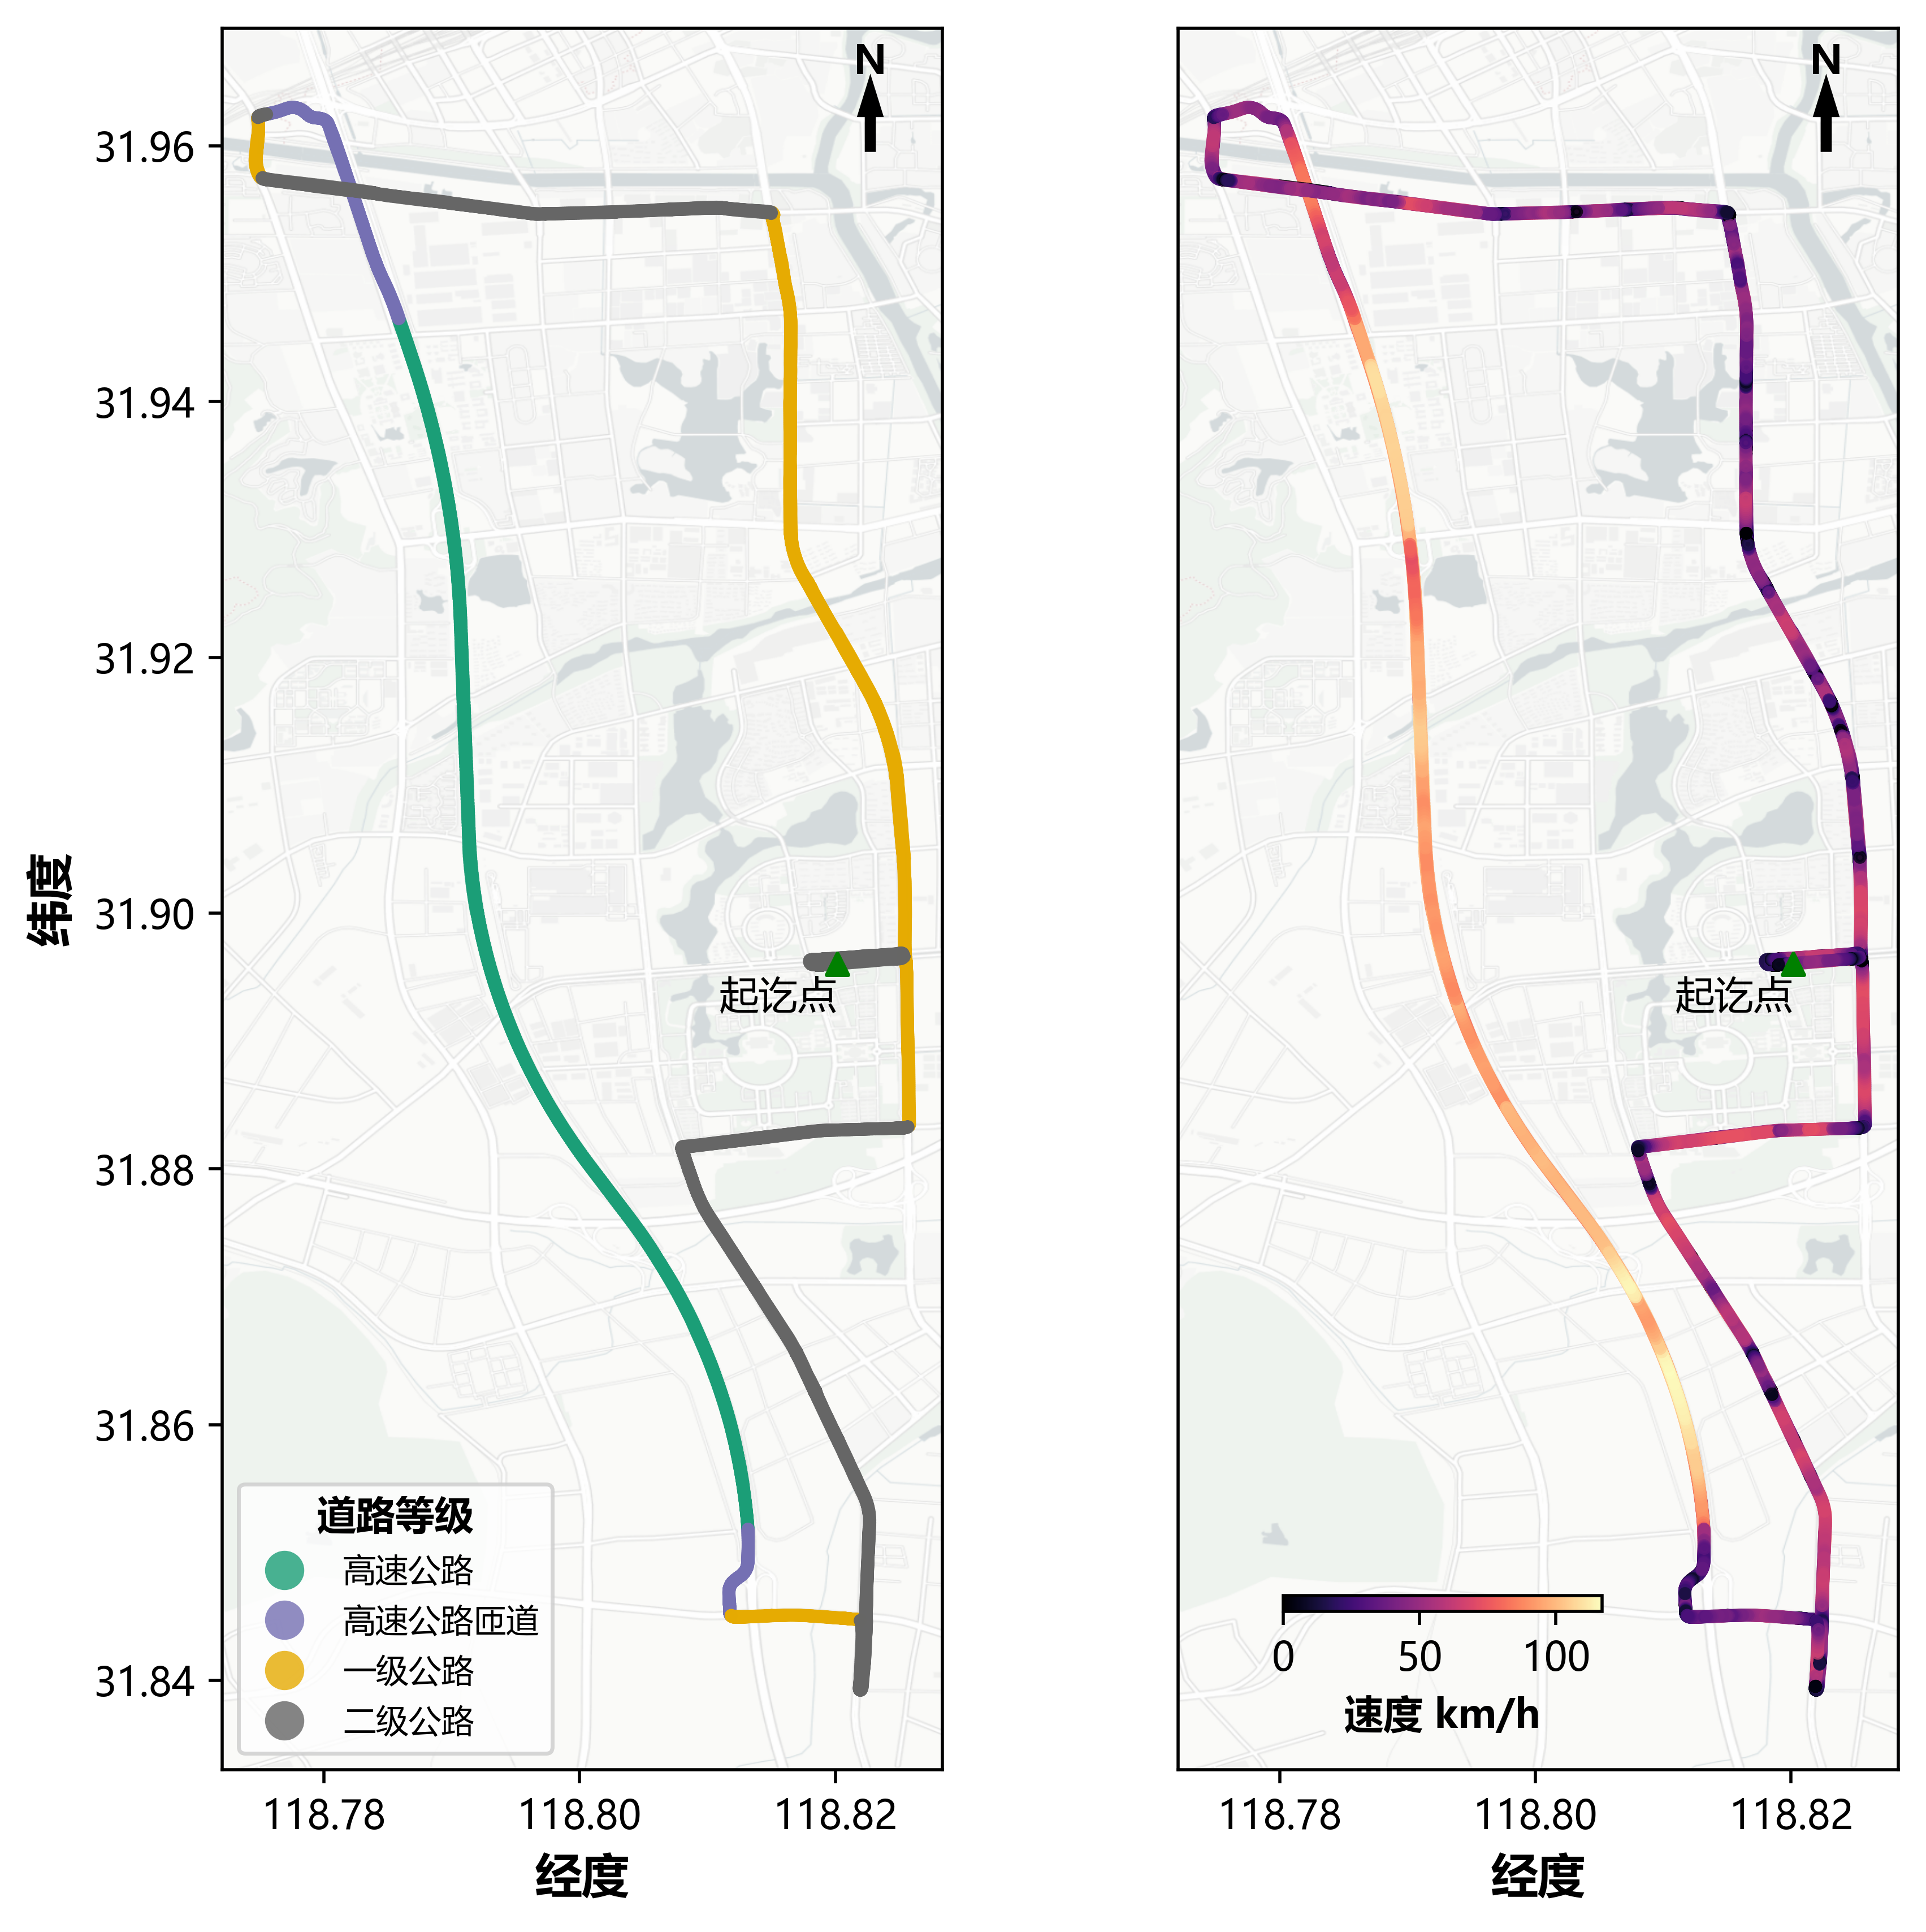

In [63]:
import contextily as ctx
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(8,8))

# transfer to geodataframe
all_gdfs = []
for key, df in trajs.items():
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'], df['lat']))
    gdf.crs = 'EPSG:4326'
    all_gdfs.append(gdf)
combined_gdf = gpd.GeoDataFrame(pd.concat(all_gdfs, ignore_index=True))

# replace wrong highway types
combined_gdf['highway'] = combined_gdf['highway'].replace({"trunk":'primary', "trunk_link":'primary', "tertiary":"secondary"})

# highway key replace
highway_dict = {
    "motorway": "高速公路",
    "motorway_link": "高速公路匝道",
    "primary": "一级公路",
    "secondary": "二级公路",
}
combined_gdf['highway_CN'] = combined_gdf['highway'].replace(highway_dict)
desired_order = ["高速公路", "高速公路匝道", "一级公路", "二级公路"]
combined_gdf['highway_CN'] = pd.Categorical(combined_gdf['highway_CN'], categories=desired_order, ordered=True)
combined_gdf = combined_gdf.sort_values(by='highway_CN')

# plot trajectory
combined_gdf.plot(
    ax=ax1, column='highway_CN', markersize=5, alpha=0.8, cmap='Dark2',
    legend=True, legend_kwds={
        'title':'道路等级', 'title_fontproperties':{'weight':'bold'},
        'loc':'lower left', 'fontsize':'small'
})
# plot speed
im = combined_gdf.plot(
    ax=ax2, column='speed[km/h]', markersize=5, alpha=0.8, cmap='magma',
    legend=True, legend_kwds={
        'location':'bottom', 'orientation':'horizontal',
        'fraction':0.1, 'pad':-0.1, 'anchor':(0.3,1), 'shrink':0.4,
        'ticks':[0,50,100],
})
cbar = im.get_figure().axes[-1]
cbar.set_xlabel('速度 km/h', fontweight='bold')

# start point and end point
first_trajectory = all_gdfs[0]
start_point = first_trajectory.iloc[0]
ax1.scatter(start_point.geometry.x, start_point.geometry.y, marker='^', color='green', s=30)
ax1.text(start_point.geometry.x, start_point.geometry.y-0.001, '起讫点', fontsize=10, color='black',
         horizontalalignment='right', verticalalignment='top')
ax2.scatter(start_point.geometry.x, start_point.geometry.y, marker='^', color='green', s=30)
ax2.text(start_point.geometry.x, start_point.geometry.y-0.001, '起讫点', fontsize=10, color='black',
         horizontalalignment='right', verticalalignment='top')

# basemap
ctx.add_basemap(ax1, crs=combined_gdf.crs.to_string(), source="https://d.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png")
ctx.add_basemap(ax2, crs=combined_gdf.crs.to_string(), source="https://d.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png")

# arrow
def add_north_arrow(ax, x, y, arrow_length, text='N', text_offset=0.03):
    ax.arrow(x, y, 0, arrow_length, transform=ax.transAxes,
             facecolor='black', edgecolor='black', width=0.01, head_width=0.03, head_length=0.02)
    ax.text(x, y + arrow_length + text_offset, text, transform=ax.transAxes,
            ha='center', va='center', fontsize=10, fontweight='bold')
add_north_arrow(ax1, 0.9, 0.93, 0.02)
add_north_arrow(ax2, 0.9, 0.93, 0.02)

# axis
ax1.set_xticks([118.78, 118.80, 118.82])
ax1.set_xlabel('经度', fontsize=12, fontweight='bold')
ax1.set_ylabel('纬度', fontsize=12, fontweight='bold')
ax2.set_xticks([118.78, 118.80, 118.82])
ax2.set_yticks([])
ax2.set_xlabel('经度', fontsize=12, fontweight='bold')

plt.show()

### params distribution

In [3]:
# data
model_driver_events = pd.read_csv("data/3-braking/model_driver_events.csv")
models = ['Sylphy', 'Corolla', 'Avalon', 'TiguanL', 'Ei5', 'ModelY']
models_CN = ['日产轩逸', '丰田卡罗拉', '丰田亚洲龙', '大众途观L', '荣威Ei5', '特斯拉ModelY']
drivers = ['DRIVER1', 'DRIVER2']

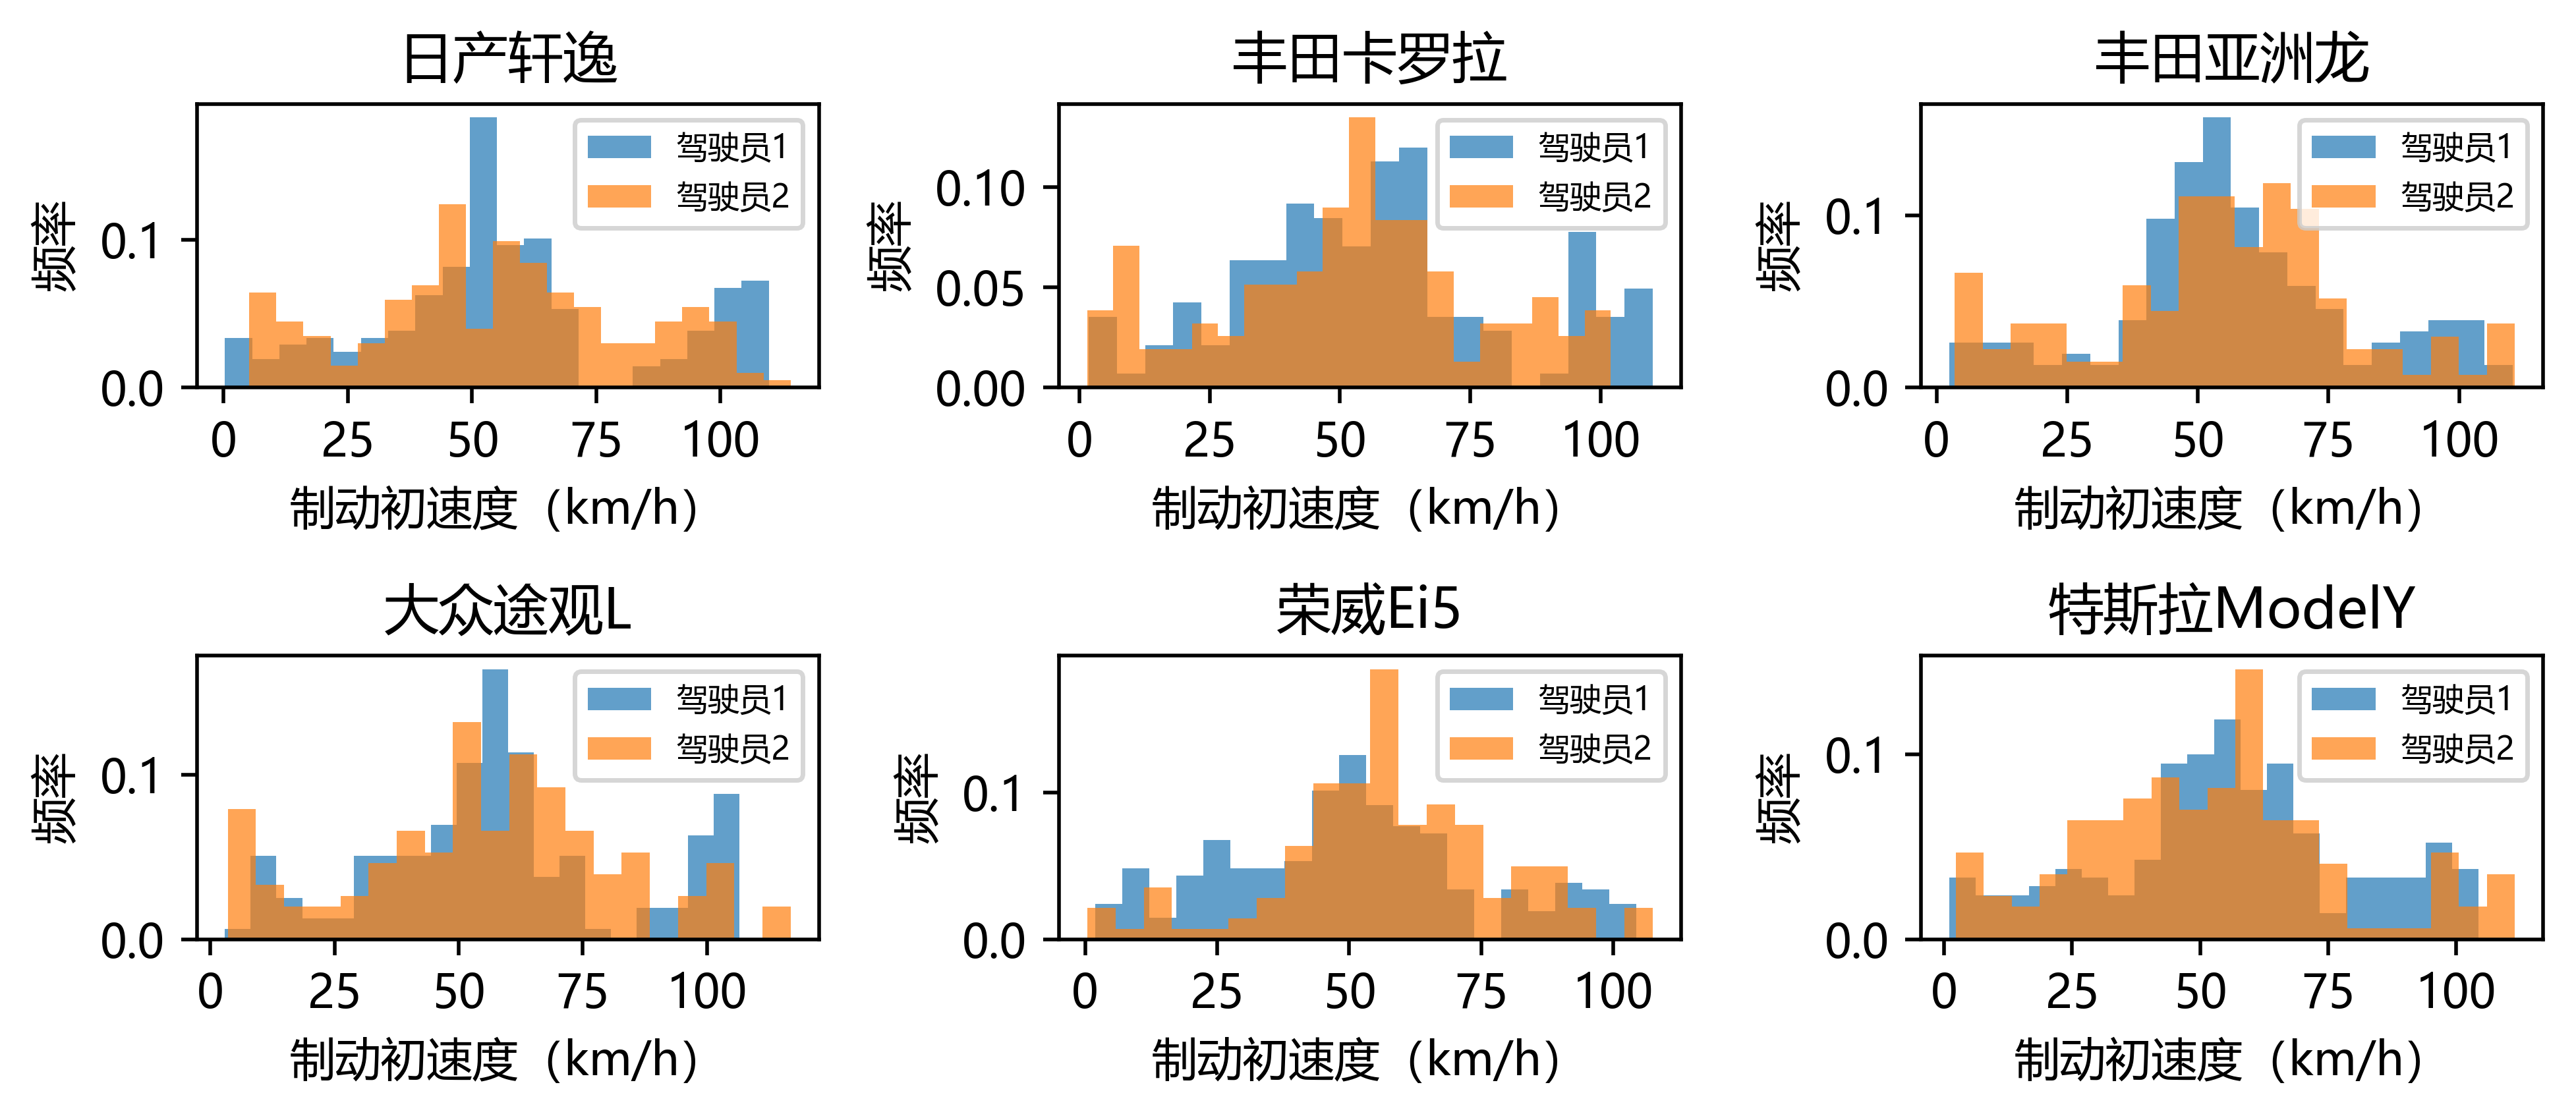

In [49]:
fig, axes = plt.subplots(2,3, figsize=(8,3.5))
axes = axes.flatten()

for i, model in enumerate(models):
    model_data = model_driver_events[model_driver_events['model'] == model]
    driver_1_data = model_data[model_data['driver'] == drivers[0]]['init_speed[km/h]']
    driver_2_data = model_data[model_data['driver'] == drivers[1]]['init_speed[km/h]']

    axes[i].hist(driver_1_data, bins=20, weights=1/len(driver_1_data)*np.ones(len(driver_1_data)), alpha=0.7, label='驾驶员1')
    axes[i].hist(driver_2_data, bins=20, weights=1/len(driver_2_data)*np.ones(len(driver_2_data)), alpha=0.7, label='驾驶员2')
    axes[i].set_title(models_CN[i])
    axes[i].set_xticks([0,25,50,75,100])
    axes[i].set_xlabel('制动初速度（km/h）')
    axes[i].set_ylabel('频率')
    axes[i].legend(fontsize='x-small')

plt.tight_layout()
plt.show()

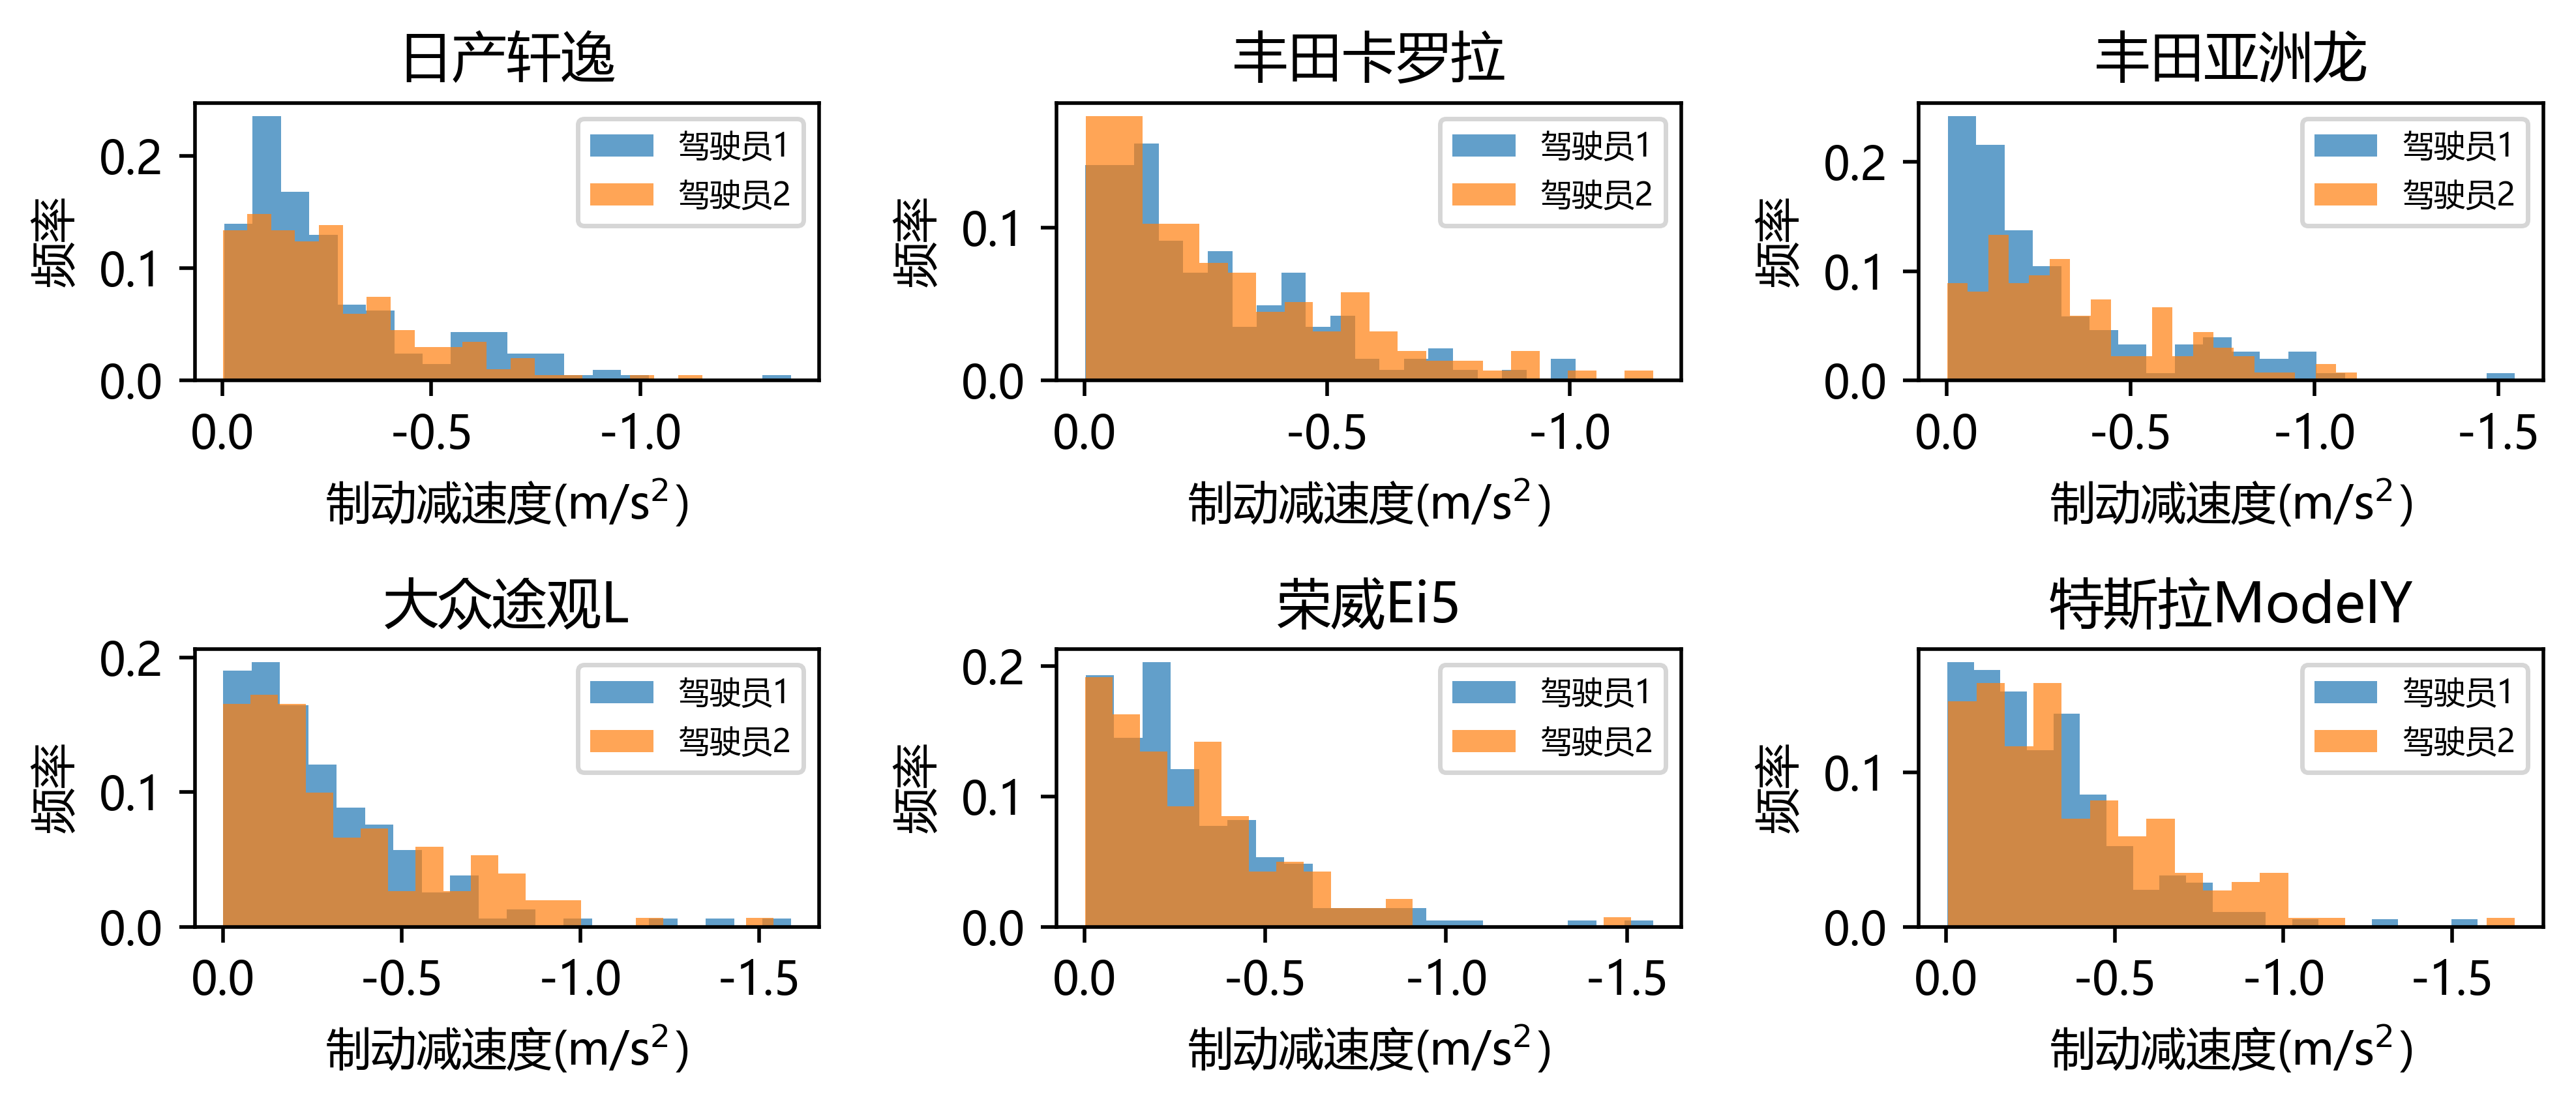

In [80]:
fig, axes = plt.subplots(2,3, figsize=(8,3.5))
axes = axes.flatten()

for i, model in enumerate(models):
    model_data = model_driver_events[model_driver_events['model'] == model]
    driver_1_data = model_data[model_data['driver'] == drivers[0]]['decel[m/s2]']
    driver_2_data = model_data[model_data['driver'] == drivers[1]]['decel[m/s2]']

    axes[i].hist(driver_1_data, bins=20, weights=1/len(driver_1_data)*np.ones(len(driver_1_data)), alpha=0.7, label='驾驶员1')
    axes[i].hist(driver_2_data, bins=20, weights=1/len(driver_2_data)*np.ones(len(driver_2_data)), alpha=0.7, label='驾驶员2')
    axes[i].set_title(models_CN[i])
    axes[i].set_xlabel('制动减速度(m/s$^2$）')
    axes[i].set_ylabel('频率')
    axes[i].legend(fontsize='x-small')
    axes[i].invert_xaxis()

plt.tight_layout()
plt.show()

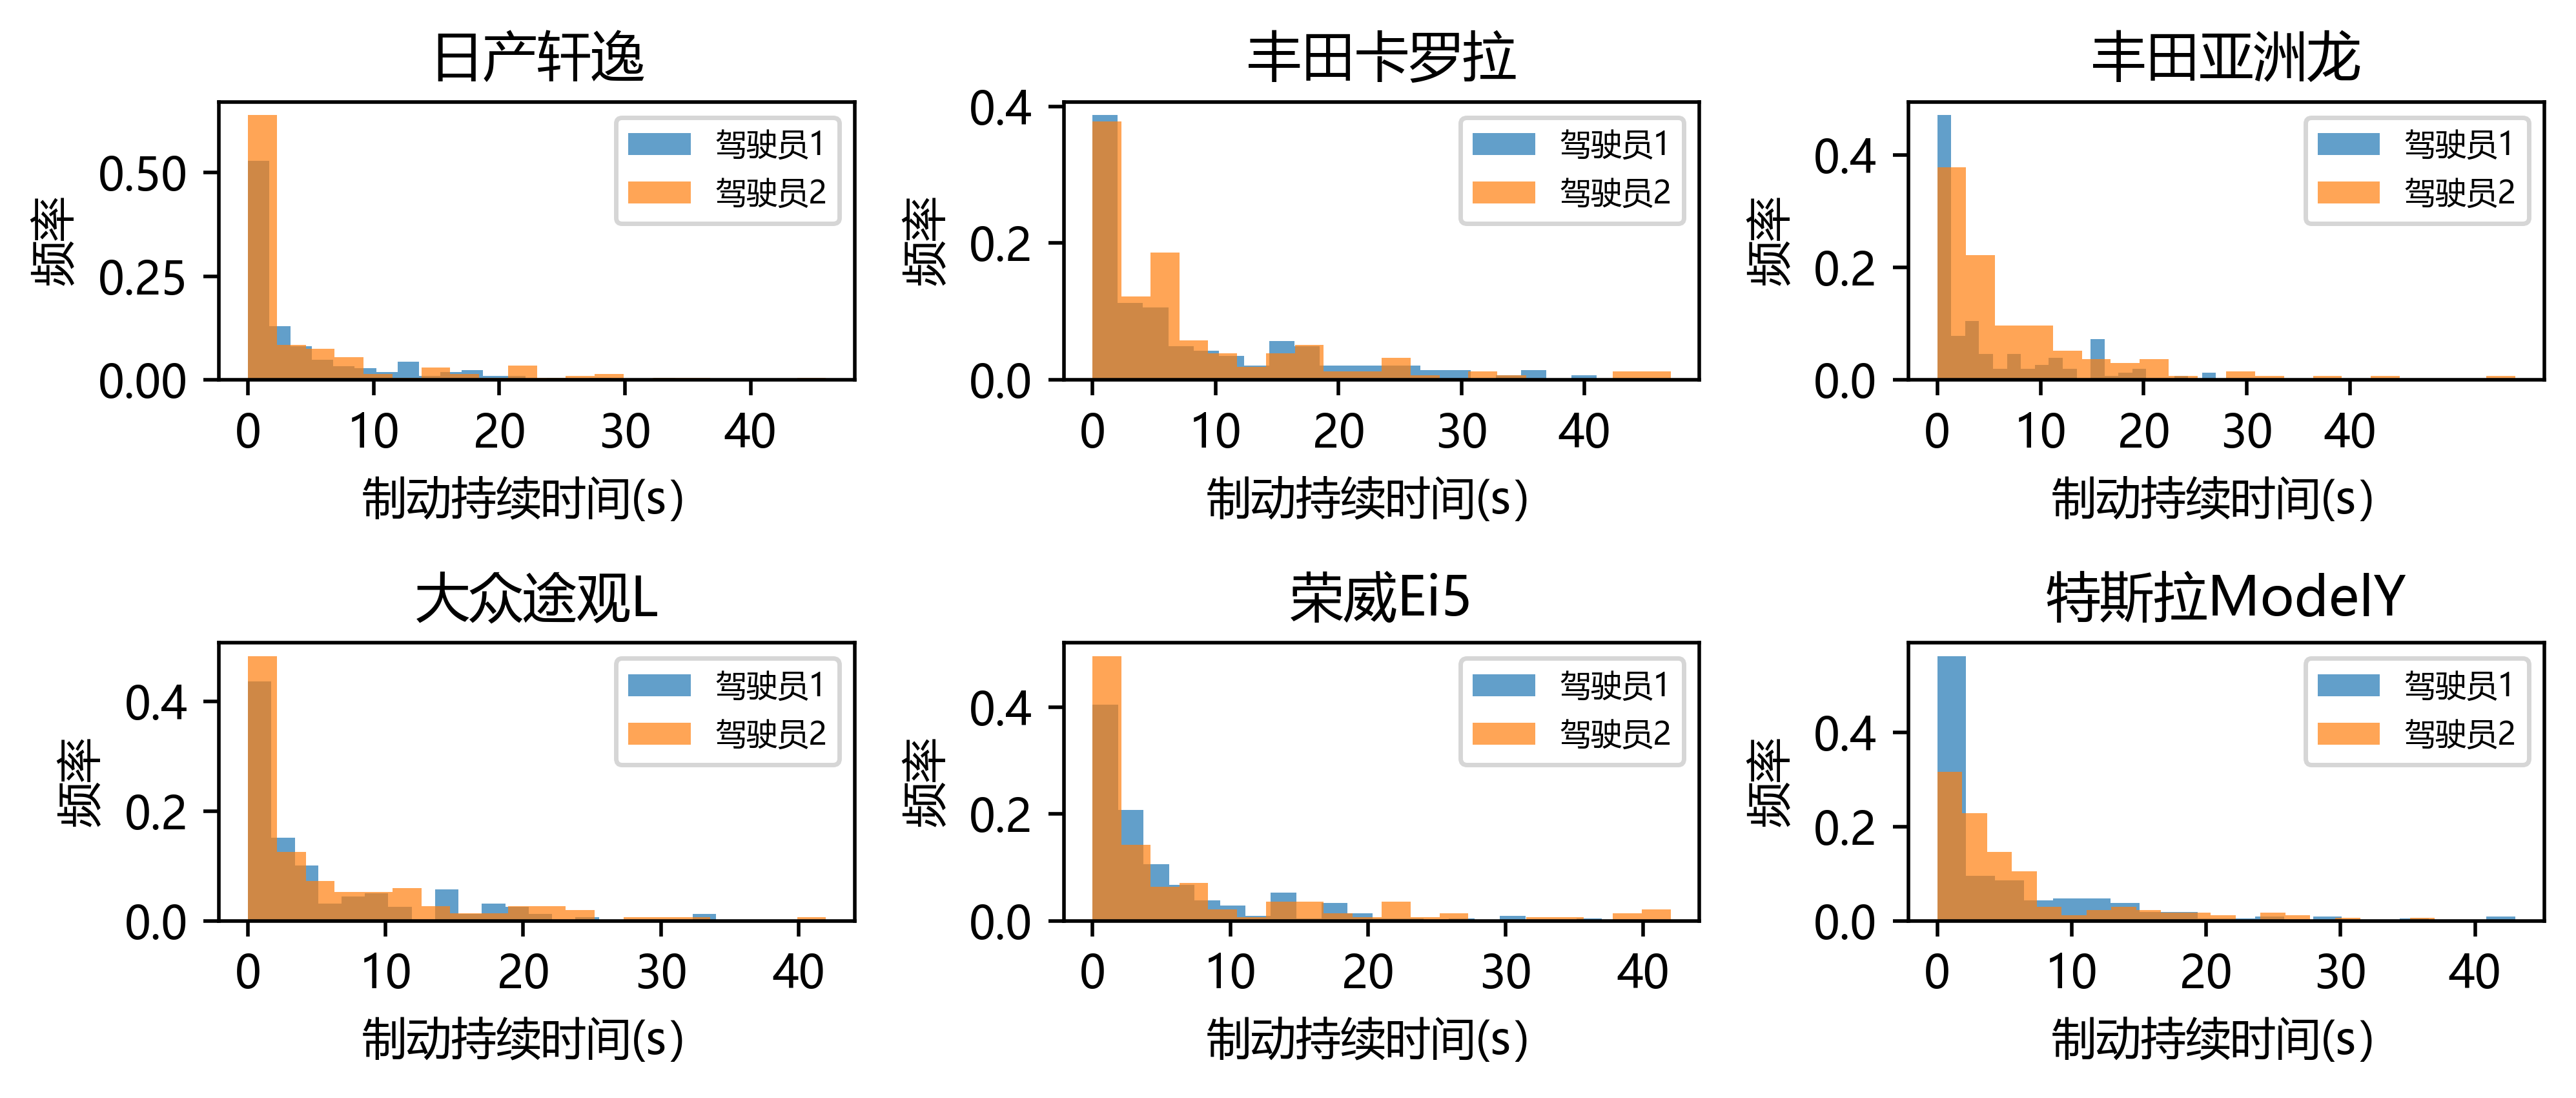

In [50]:
fig, axes = plt.subplots(2,3, figsize=(8,3.5))
axes = axes.flatten()

for i, model in enumerate(models):
    model_data = model_driver_events[model_driver_events['model'] == model]
    driver_1_data = model_data[model_data['driver'] == drivers[0]]['braking_t[s]']
    driver_2_data = model_data[model_data['driver'] == drivers[1]]['braking_t[s]']

    axes[i].hist(driver_1_data, bins=20, weights=1/len(driver_1_data)*np.ones(len(driver_1_data)), alpha=0.7, label='驾驶员1')
    axes[i].hist(driver_2_data, bins=20, weights=1/len(driver_2_data)*np.ones(len(driver_2_data)), alpha=0.7, label='驾驶员2')
    axes[i].set_title(models_CN[i])
    axes[i].set_xticks([0,10,20,30,40])
    axes[i].set_xlabel('制动持续时间(s）')
    axes[i].set_ylabel('频率')
    axes[i].legend(fontsize='x-small')

plt.tight_layout()
plt.show()

### impact of speed

In [64]:
# speed bins
all_dfs = []
for key, df in trajs.items():
    all_dfs.append(df)
combined_df = gpd.GeoDataFrame(pd.concat(all_dfs, ignore_index=True))

model_driver_events = pd.read_csv("data/3-braking/model_driver_events.csv")
model_driver_events['speed_bin'] = pd.cut(model_driver_events['init_speed[km/h]'], bins=np.arange(0,130,10))
combined_df['speed_bin'] = pd.cut(combined_df['speed[km/h]'], bins=np.arange(0,130,10))

In [65]:
braking_time = model_driver_events[['speed_bin', 'braking_t[s]']].groupby(by='speed_bin').sum()
braking_event = model_driver_events[['speed_bin', 'event_id']].groupby(by='speed_bin').apply(lambda group: len(group))
total_time = combined_df[['speed_bin', 'sec']].groupby(by='speed_bin').apply(lambda group: len(group))
total_mileage = combined_df[['speed_bin', 'd_gap[m]']].groupby(by='speed_bin').sum()

speed_bin_amount = pd.concat([braking_time, braking_event, total_time, total_mileage], axis=1)
speed_bin_amount.columns = ['braking_t[s]', 'braking_n', 'duration[s]', 'mileage[m]']
speed_bin_amount['braking_frac'] = speed_bin_amount['braking_t[s]'] / speed_bin_amount['duration[s]']
speed_bin_amount['braking_freq'] = speed_bin_amount['braking_n'] / speed_bin_amount['mileage[m]'] * 1000
speed_bin_amount.reset_index(inplace=True)

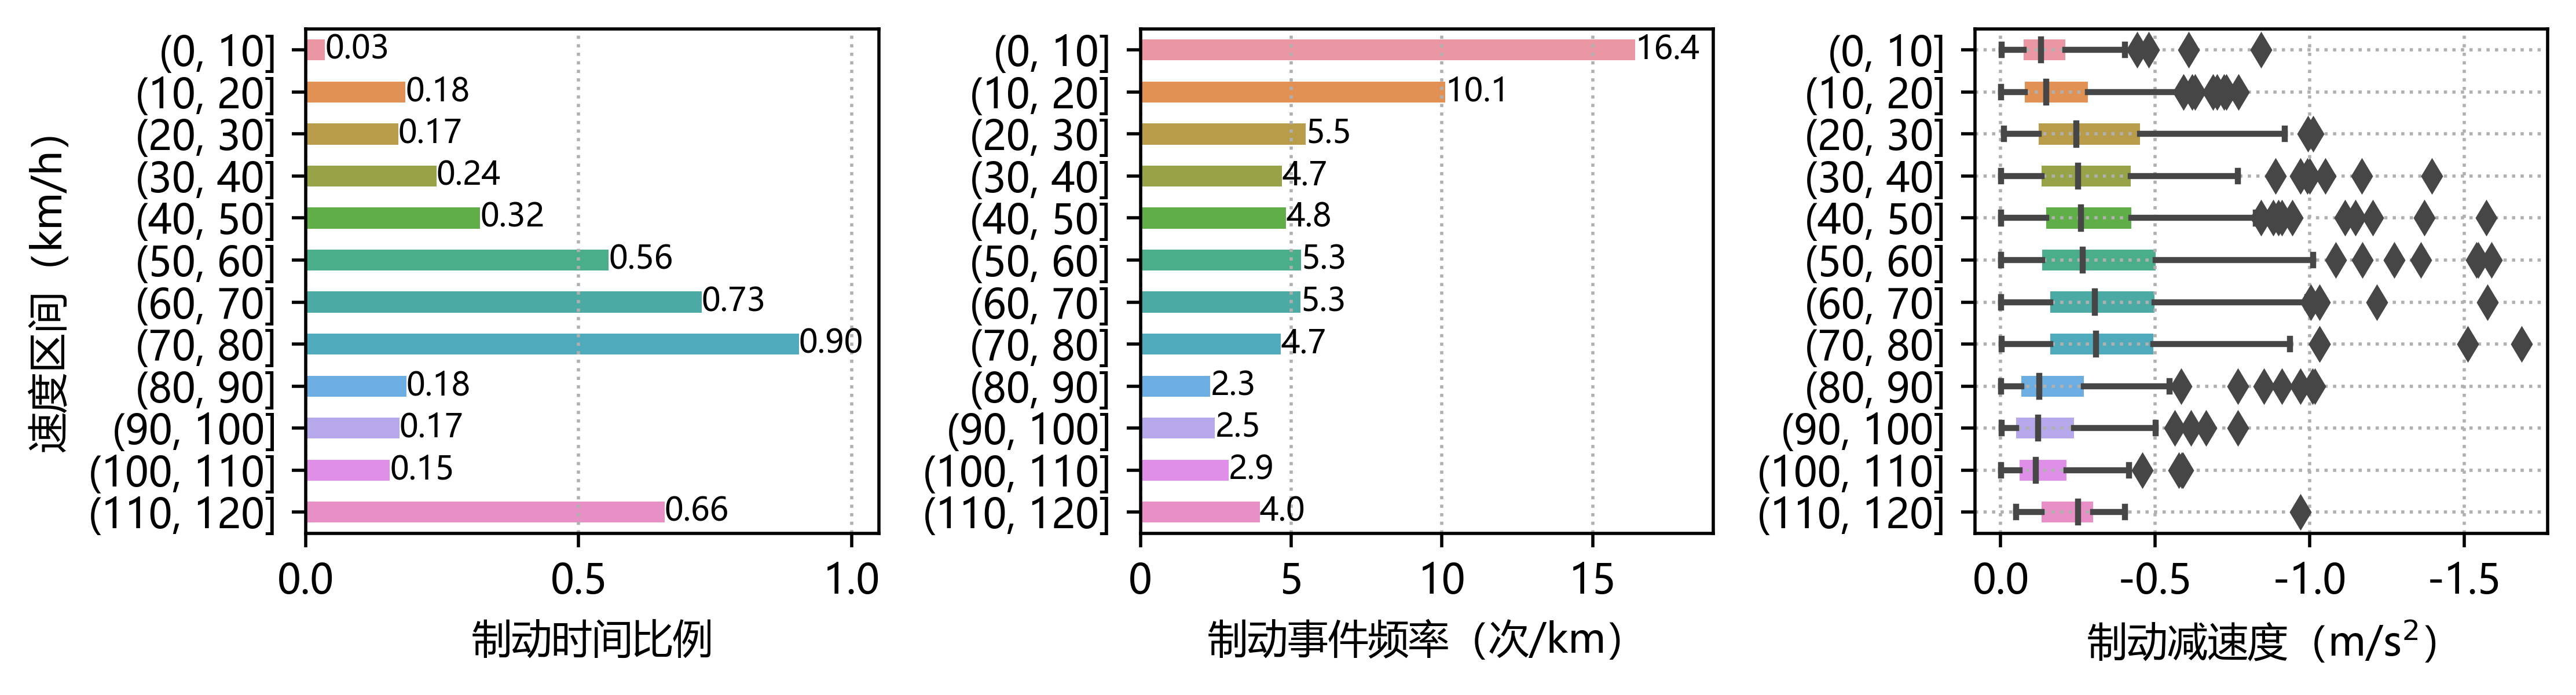

In [79]:
import seaborn as sns

fig, axes = plt.subplots(1,3, figsize=(9,2.5))

# fig1: braking fraction
sns.barplot(data=speed_bin_amount, y='speed_bin', x='braking_frac', width=0.5, orient='h', ax=axes[0])
for p in axes[0].patches:
    width = p.get_width()
    axes[0].text(width, p.get_y() + p.get_height() / 2., '{:1.2f}'.format(width), fontsize=8, ha='left', va='center')
axes[0].set_xlabel("制动时间比例")
axes[0].set_ylabel("速度区间（km/h）")
axes[0].set_xlim(0, 1.05)
axes[0].grid(axis="x", linestyle=":")

# fig2: braking frequency
sns.barplot(data=speed_bin_amount, y='speed_bin', x='braking_freq', width=0.5, orient='h', ax=axes[1])
for p in axes[1].patches:
    width = p.get_width()
    axes[1].text(width, p.get_y() + p.get_height() / 2., '{:.1f}'.format(width), fontsize=8, ha='left', va='center')
axes[1].set_xlabel("制动事件频率（次/km）")
axes[1].set_ylabel("")
axes[1].grid(axis="x", linestyle=":")
axes[1].set_xlim(0, 19)

# fig3: decel
sns.boxplot(data=model_driver_events, y='speed_bin', x='decel[m/s2]', width=0.5, orient='h', boxprops={"edgecolor": "none"}, ax=axes[2])
axes[2].set_xlabel("制动减速度（m/s$^2$）")
axes[2].set_ylabel("")
axes[2].grid(linestyle=":")
axes[2].invert_xaxis()

plt.tight_layout()
plt.show()

### impact of weight

In [4]:
model_driver_events = pd.read_csv("data/3-braking/model_driver_events.csv")
model_mean = model_driver_events[['model', 'braking_t[s]', 'init_speed[km/h]', 'decel[m/s2]', 'weight']].groupby(by=['model']).mean()
model_mean = model_mean.sort_values(by='weight').reset_index()
model_mean['weight'] += 120

In [24]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(model_mean['weight'], model_mean['decel[m/s2]'])

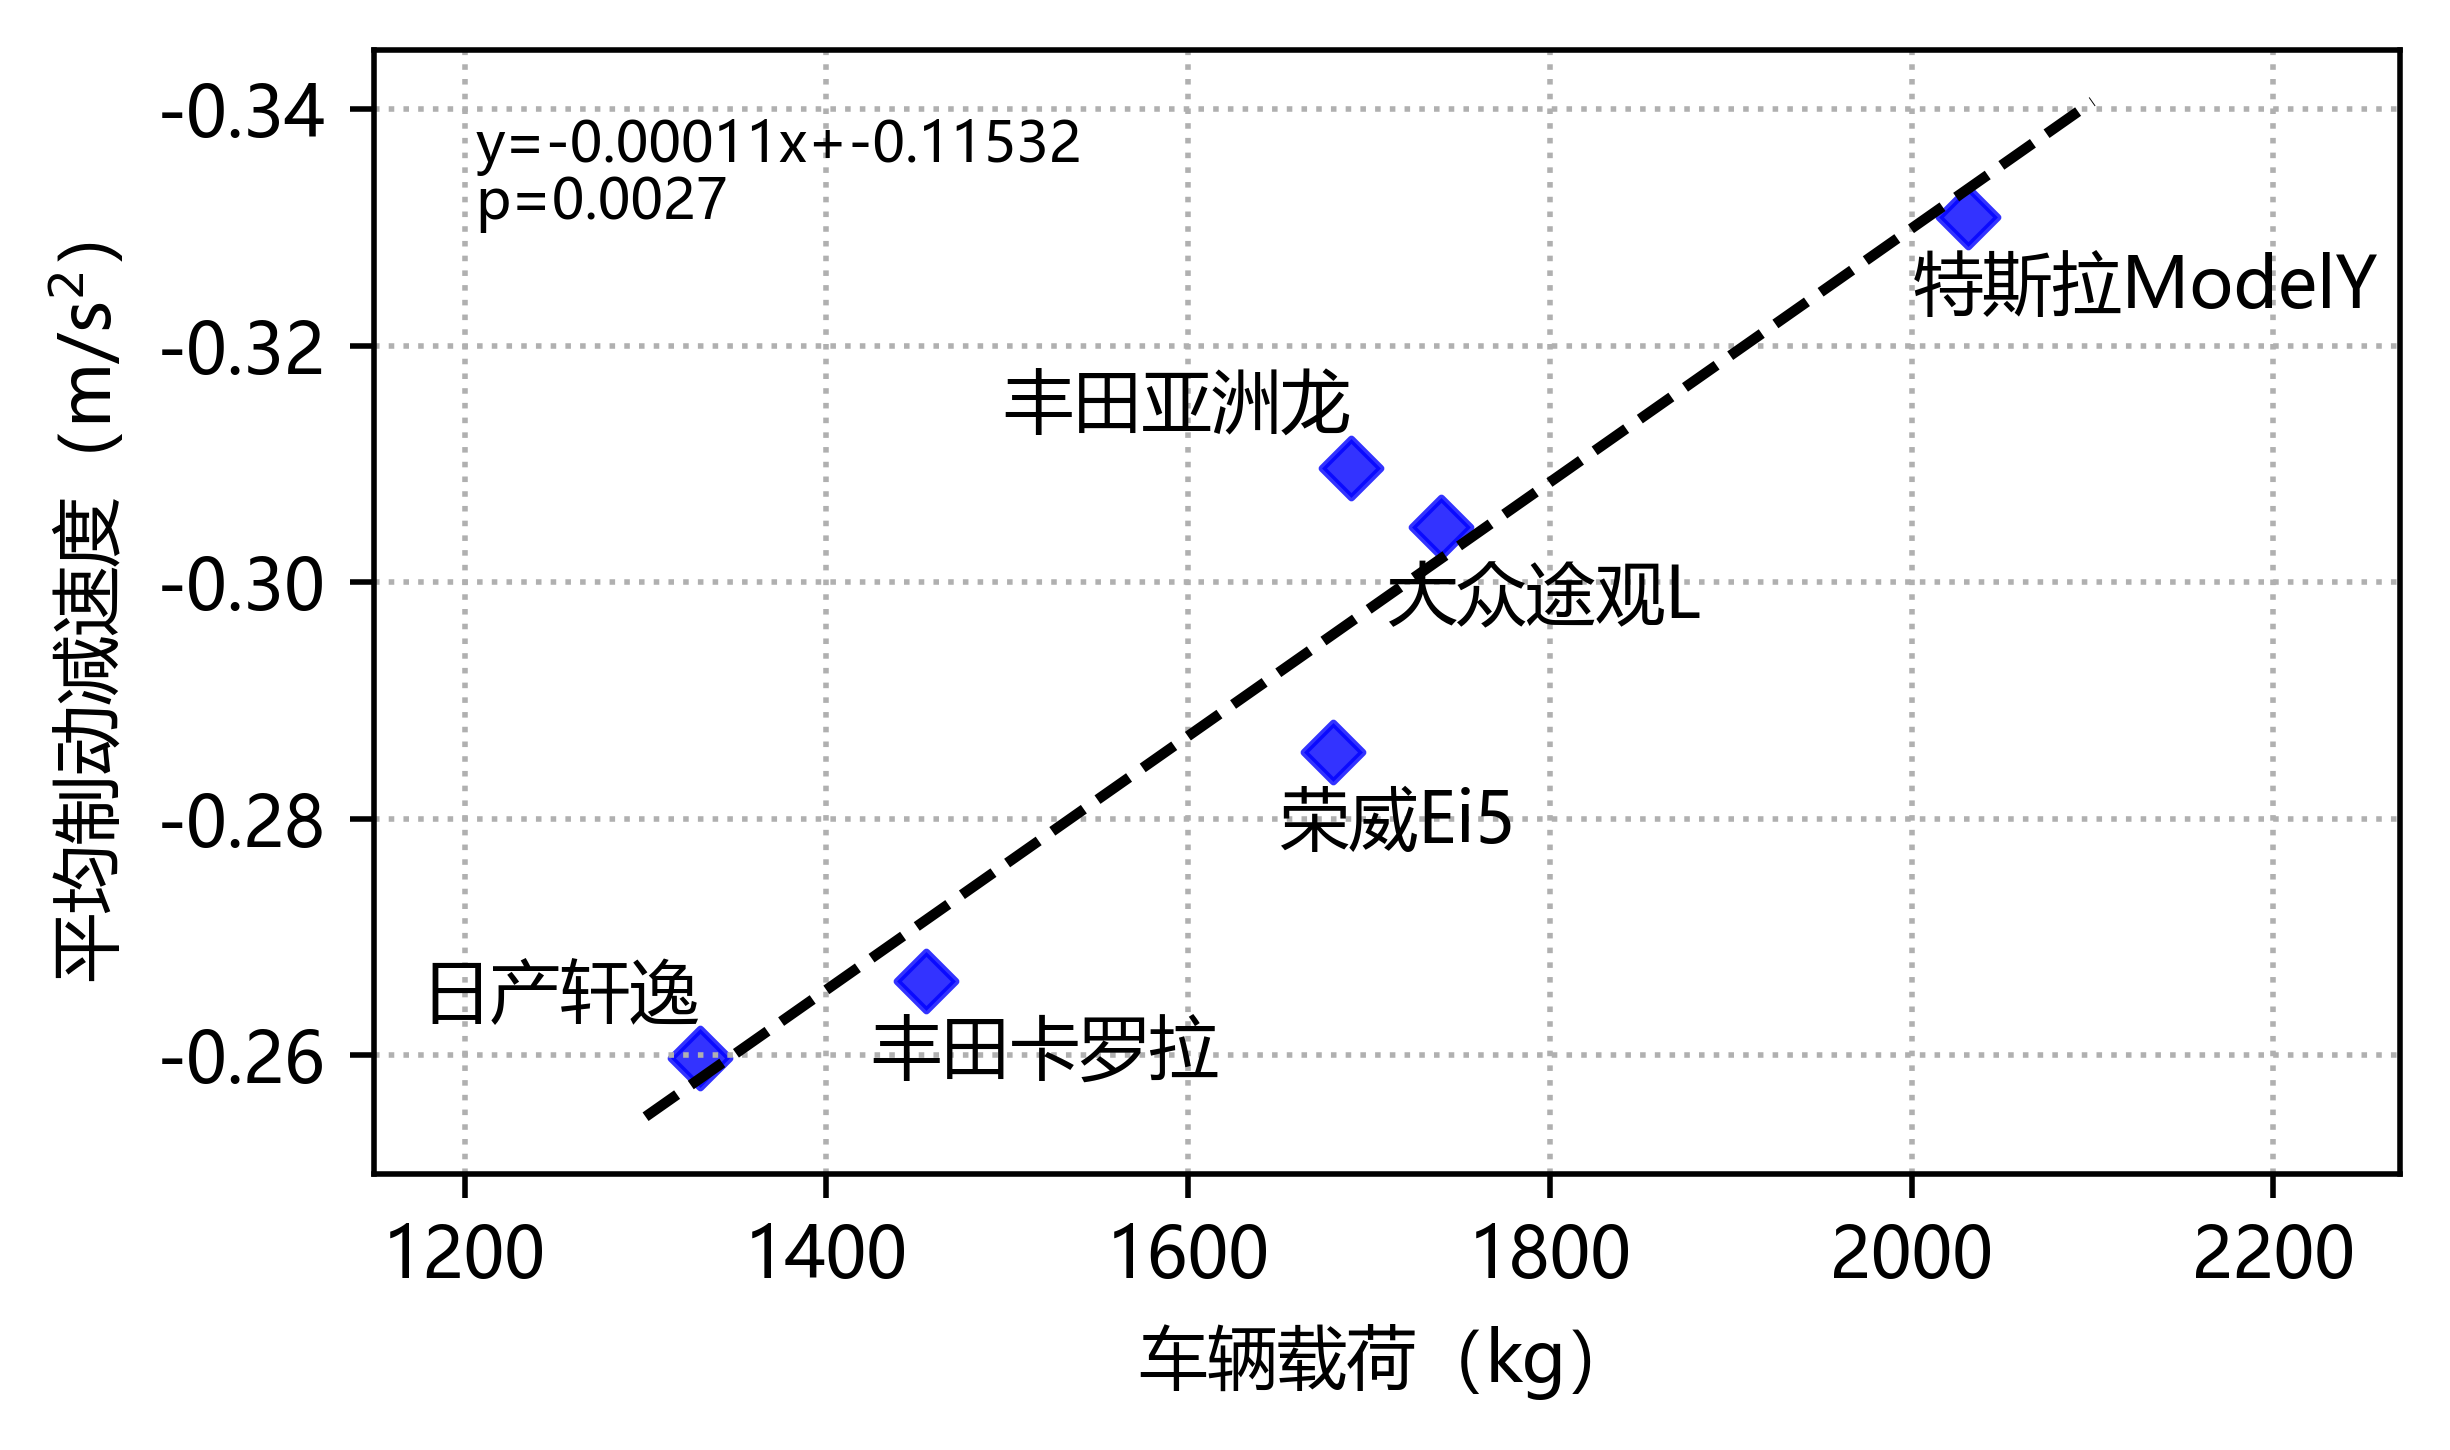

In [46]:
fig, axes = plt.subplots(1,1,figsize=(5,3))

# data point
plt.scatter(model_mean['weight'], model_mean['decel[m/s2]'], marker='D', color='blue', alpha=0.8)

# text
models = ['Sylphy', 'Corolla', 'Avalon', 'TiguanL', 'Ei5', 'ModelY']
models_CN = ['日产轩逸', '丰田卡罗拉', '丰田亚洲龙', '大众途观L', '荣威Ei5', '特斯拉ModelY']
for i, model in enumerate(models):
    data = model_mean[model_mean['model'] == model].iloc[0]
    if model in ['Corolla', 'TiguanL', 'Ei5', 'ModelY']:
        plt.text(data['weight']-30, data['decel[m/s2]']+0.003, models_CN[i], va='top', ha='left')
    else:
        plt.text(data['weight'], data['decel[m/s2]']-0.002, models_CN[i], va='bottom', ha='right')

# fitted line
x_fit = np.linspace(1300, 2100, 100)
y_fit = slope * x_fit + intercept
plt.plot(x_fit, y_fit, linestyle='--', color='k')
equation = f'y={slope:.5f}x+{intercept:.5f}'
plt.text(0.05, 0.9, equation, color='k', fontsize=8,  transform=plt.gca().transAxes)
plt.text(0.05, 0.85, f'p={p_value:.4f}', color='k', fontsize=8, transform=plt.gca().transAxes)

plt.xlim(1150,2270)
plt.ylim(-0.345, -0.25)
plt.xlabel("车辆载荷（kg）")
plt.ylabel("平均制动减速度（m/s$^2$）")

plt.grid(linestyle=":")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### impact of regenerative braking

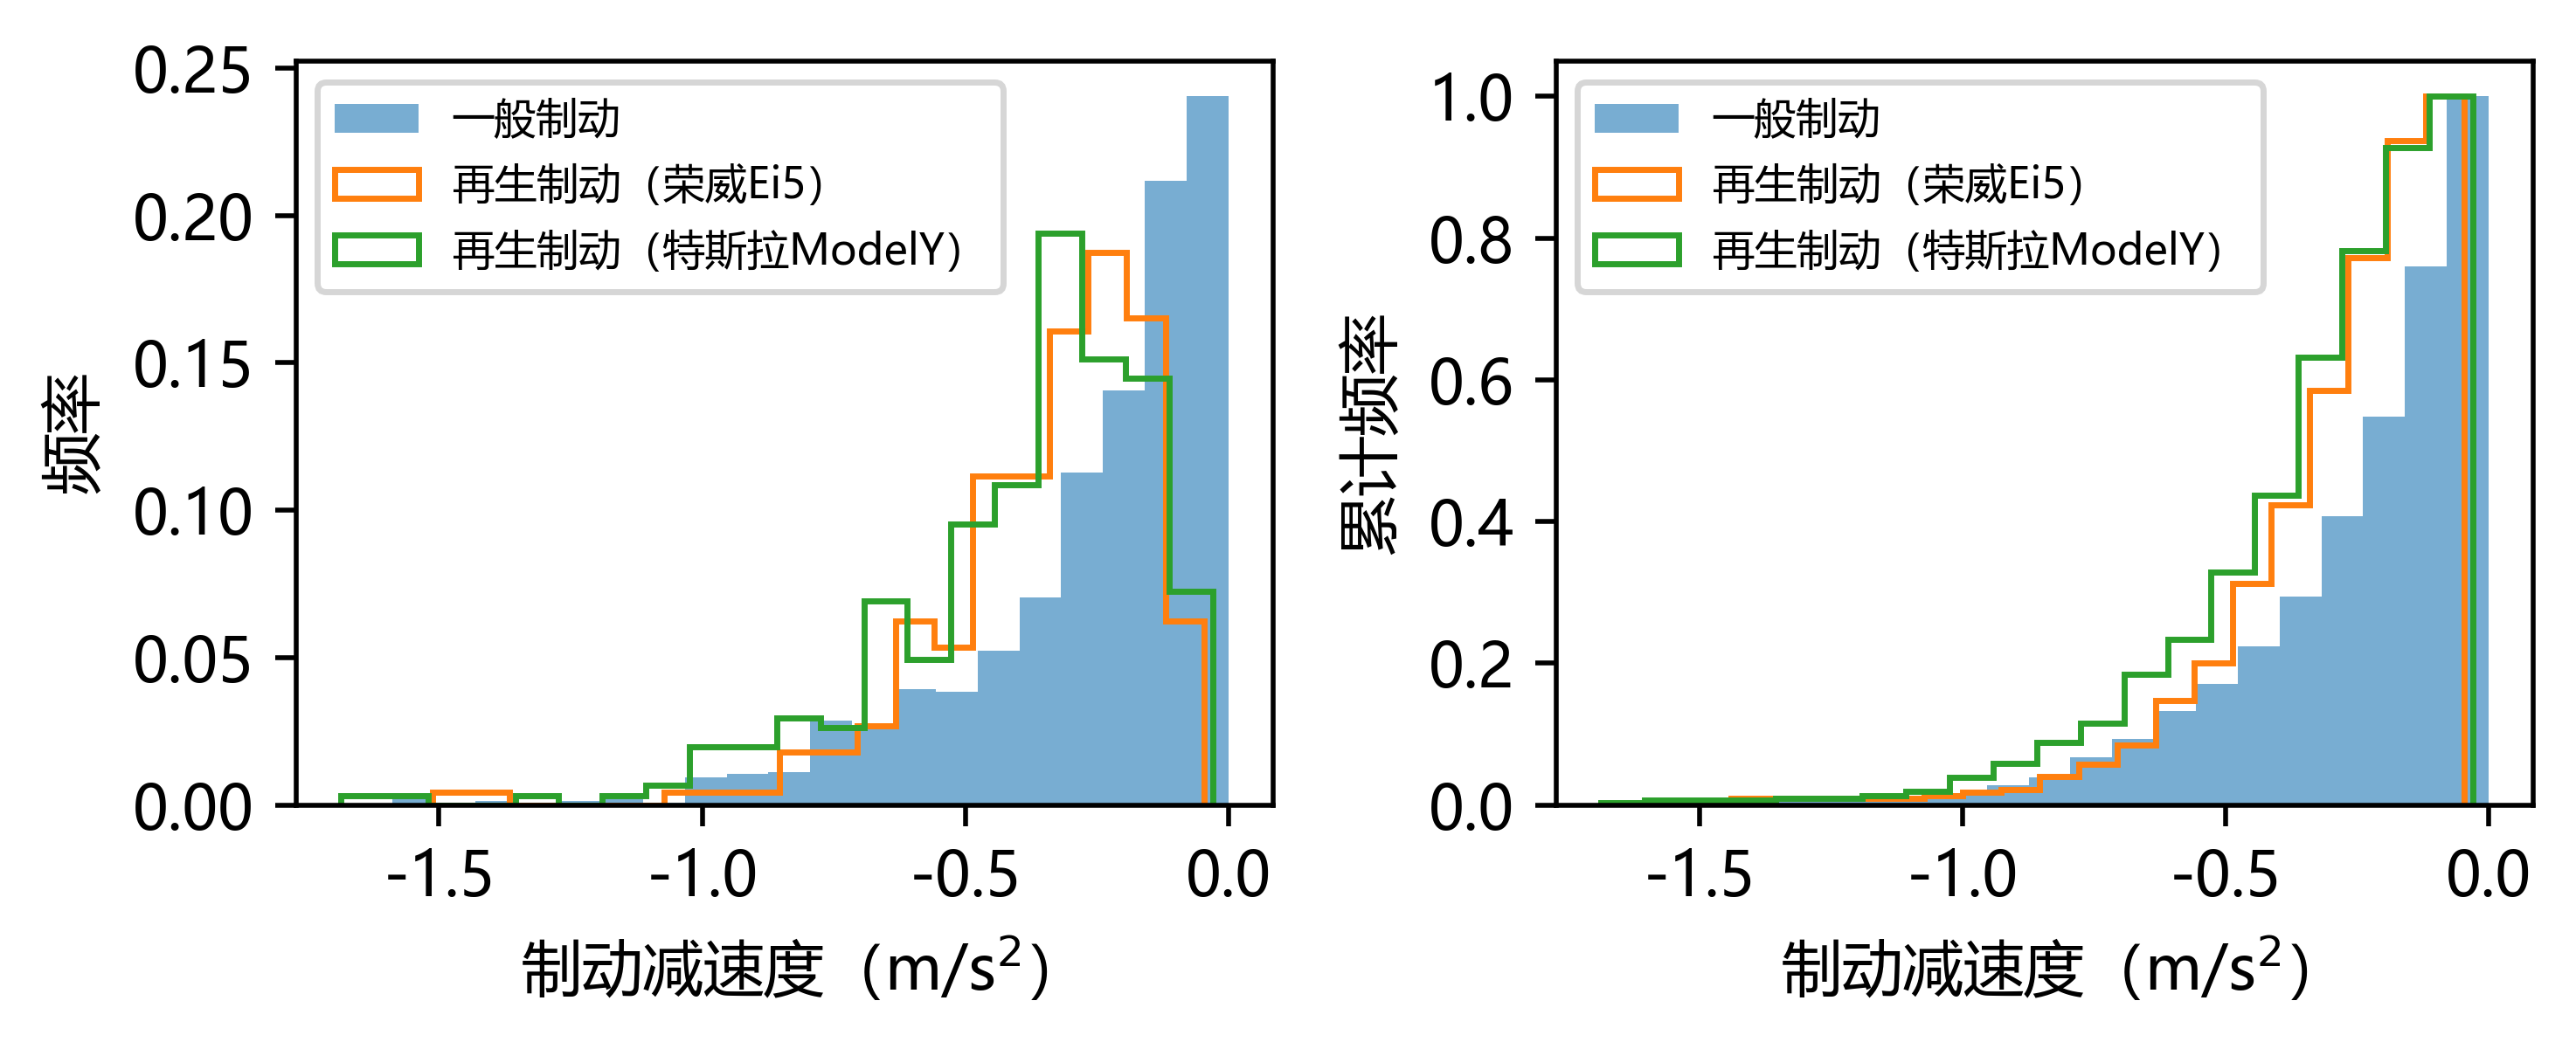

In [5]:
braking = model_driver_events[(model_driver_events['reg_braking_t[s]'] == 0)]
reg_braking_Ei5 = model_driver_events[(model_driver_events['model'] == 'Ei5') & (model_driver_events['reg_braking_t[s]'] != 0)]
reg_braking_ModelY = model_driver_events[(model_driver_events['model'] == 'ModelY') & (model_driver_events['reg_braking_t[s]'] != 0)]

fig, axes = plt.subplots(1,2, figsize=(6,2.5))

data1 = braking['decel[m/s2]']
data2 = reg_braking_Ei5['decel[m/s2]']
data3 = reg_braking_ModelY['decel[m/s2]']

axes[0].hist(data1, bins=20, weights=1/len(data1)*np.ones(len(data1)), histtype='stepfilled', alpha=0.6, label='一般制动')
axes[0].hist(data2, bins=20, weights=1/len(data2)*np.ones(len(data2)), histtype='step', alpha=1, label='再生制动（荣威Ei5）')
axes[0].hist(data3, bins=20, weights=1/len(data3)*np.ones(len(data3)), histtype='step', alpha=1, label='再生制动（特斯拉ModelY）')
axes[0].set_xlabel('制动减速度（m/s$^2$）')
axes[0].set_ylabel('频率')
axes[0].legend(fontsize='x-small')

axes[1].hist(data1, bins=20, weights=1/len(data1)*np.ones(len(data1)), cumulative=True, histtype='stepfilled', alpha=0.6, label='一般制动')
axes[1].hist(data2, bins=20, weights=1/len(data2)*np.ones(len(data2)), cumulative=True, histtype='step', alpha=1, label='再生制动（荣威Ei5）')
axes[1].hist(data3, bins=20, weights=1/len(data3)*np.ones(len(data3)), cumulative=True, histtype='step', alpha=1, label='再生制动（特斯拉ModelY）')
axes[1].set_xlabel('制动减速度（m/s$^2$）')
axes[1].set_ylabel('累计频率')
axes[1].legend(fontsize='x-small')

plt.tight_layout()
plt.show()

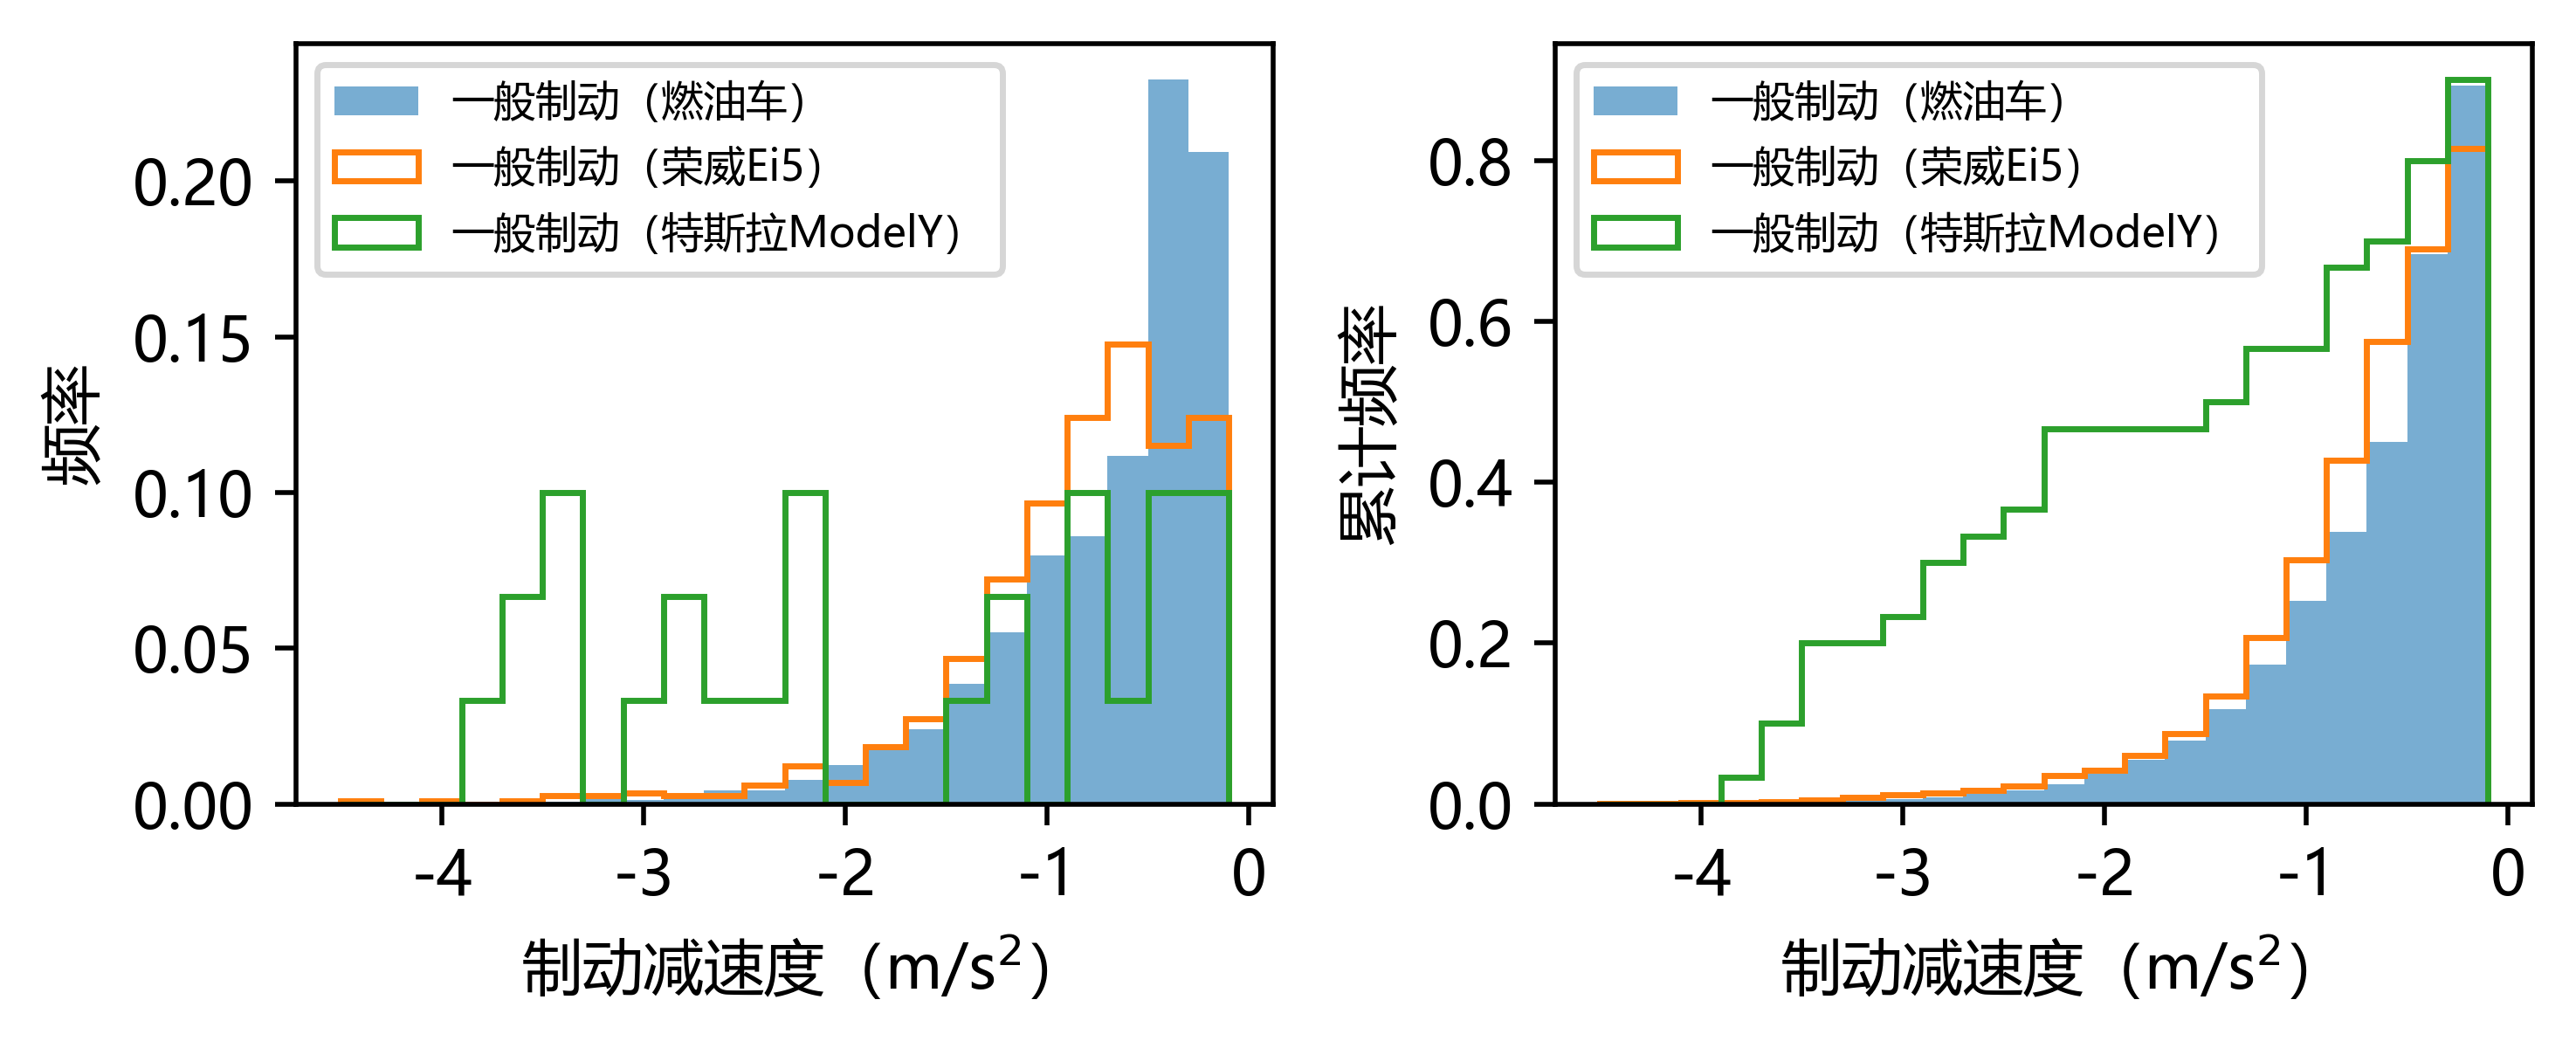

In [7]:
decel_set = pd.read_csv("data/3-braking/decel_set.csv")
braking_ei5 = decel_set[(decel_set['model'] == 'Ei5') & (decel_set['braking'] == 1) & (decel_set['reg'] == 0)].copy()
braking_modely = decel_set[(decel_set['model'] == 'ModelY') & (decel_set['braking'] == 1) & (decel_set['reg'] == 0)].copy()
braking_icev = decel_set[(~decel_set['model'].isin(['Ei5', 'ModelY'])) & (decel_set['braking'] == 1)].copy()

fig, axes = plt.subplots(1,2, figsize=(6,2.5))

data1 = braking_icev['acc[m/s2]']
data2 = braking_ei5['acc[m/s2]']
data3 = braking_modely['acc[m/s2]']
bins = np.arange(-4.5,0.1,0.2)
axes[0].hist(data1, bins=bins, weights=1/len(data1)*np.ones(len(data1)), histtype='stepfilled', alpha=0.6, label='一般制动（燃油车）')
axes[0].hist(data2, bins=bins, weights=1/len(data2)*np.ones(len(data2)), histtype='step', alpha=1, label='一般制动（荣威Ei5）')
axes[0].hist(data3, bins=bins, weights=1/len(data3)*np.ones(len(data3)), histtype='step', alpha=1, label='一般制动（特斯拉ModelY）')
# axes[0].set_xlim(-2,0)
axes[0].set_xlabel('制动减速度（m/s$^2$）')
axes[0].set_ylabel('频率')
axes[0].legend(fontsize='x-small')

axes[1].hist(data1, bins=bins, weights=1/len(data1)*np.ones(len(data1)), cumulative=True, histtype='stepfilled', alpha=0.6, label='一般制动（燃油车）')
axes[1].hist(data2, bins=bins, weights=1/len(data2)*np.ones(len(data2)), cumulative=True, histtype='step', alpha=1, label='一般制动（荣威Ei5）')
axes[1].hist(data3, bins=bins, weights=1/len(data3)*np.ones(len(data3)), cumulative=True, histtype='step', alpha=1, label='一般制动（特斯拉ModelY）')
# axes[1].set_xlim(-2,0)
axes[1].set_xlabel('制动减速度（m/s$^2$）')
axes[1].set_ylabel('累计频率')
axes[1].legend(fontsize='x-small')

plt.tight_layout()
plt.show()

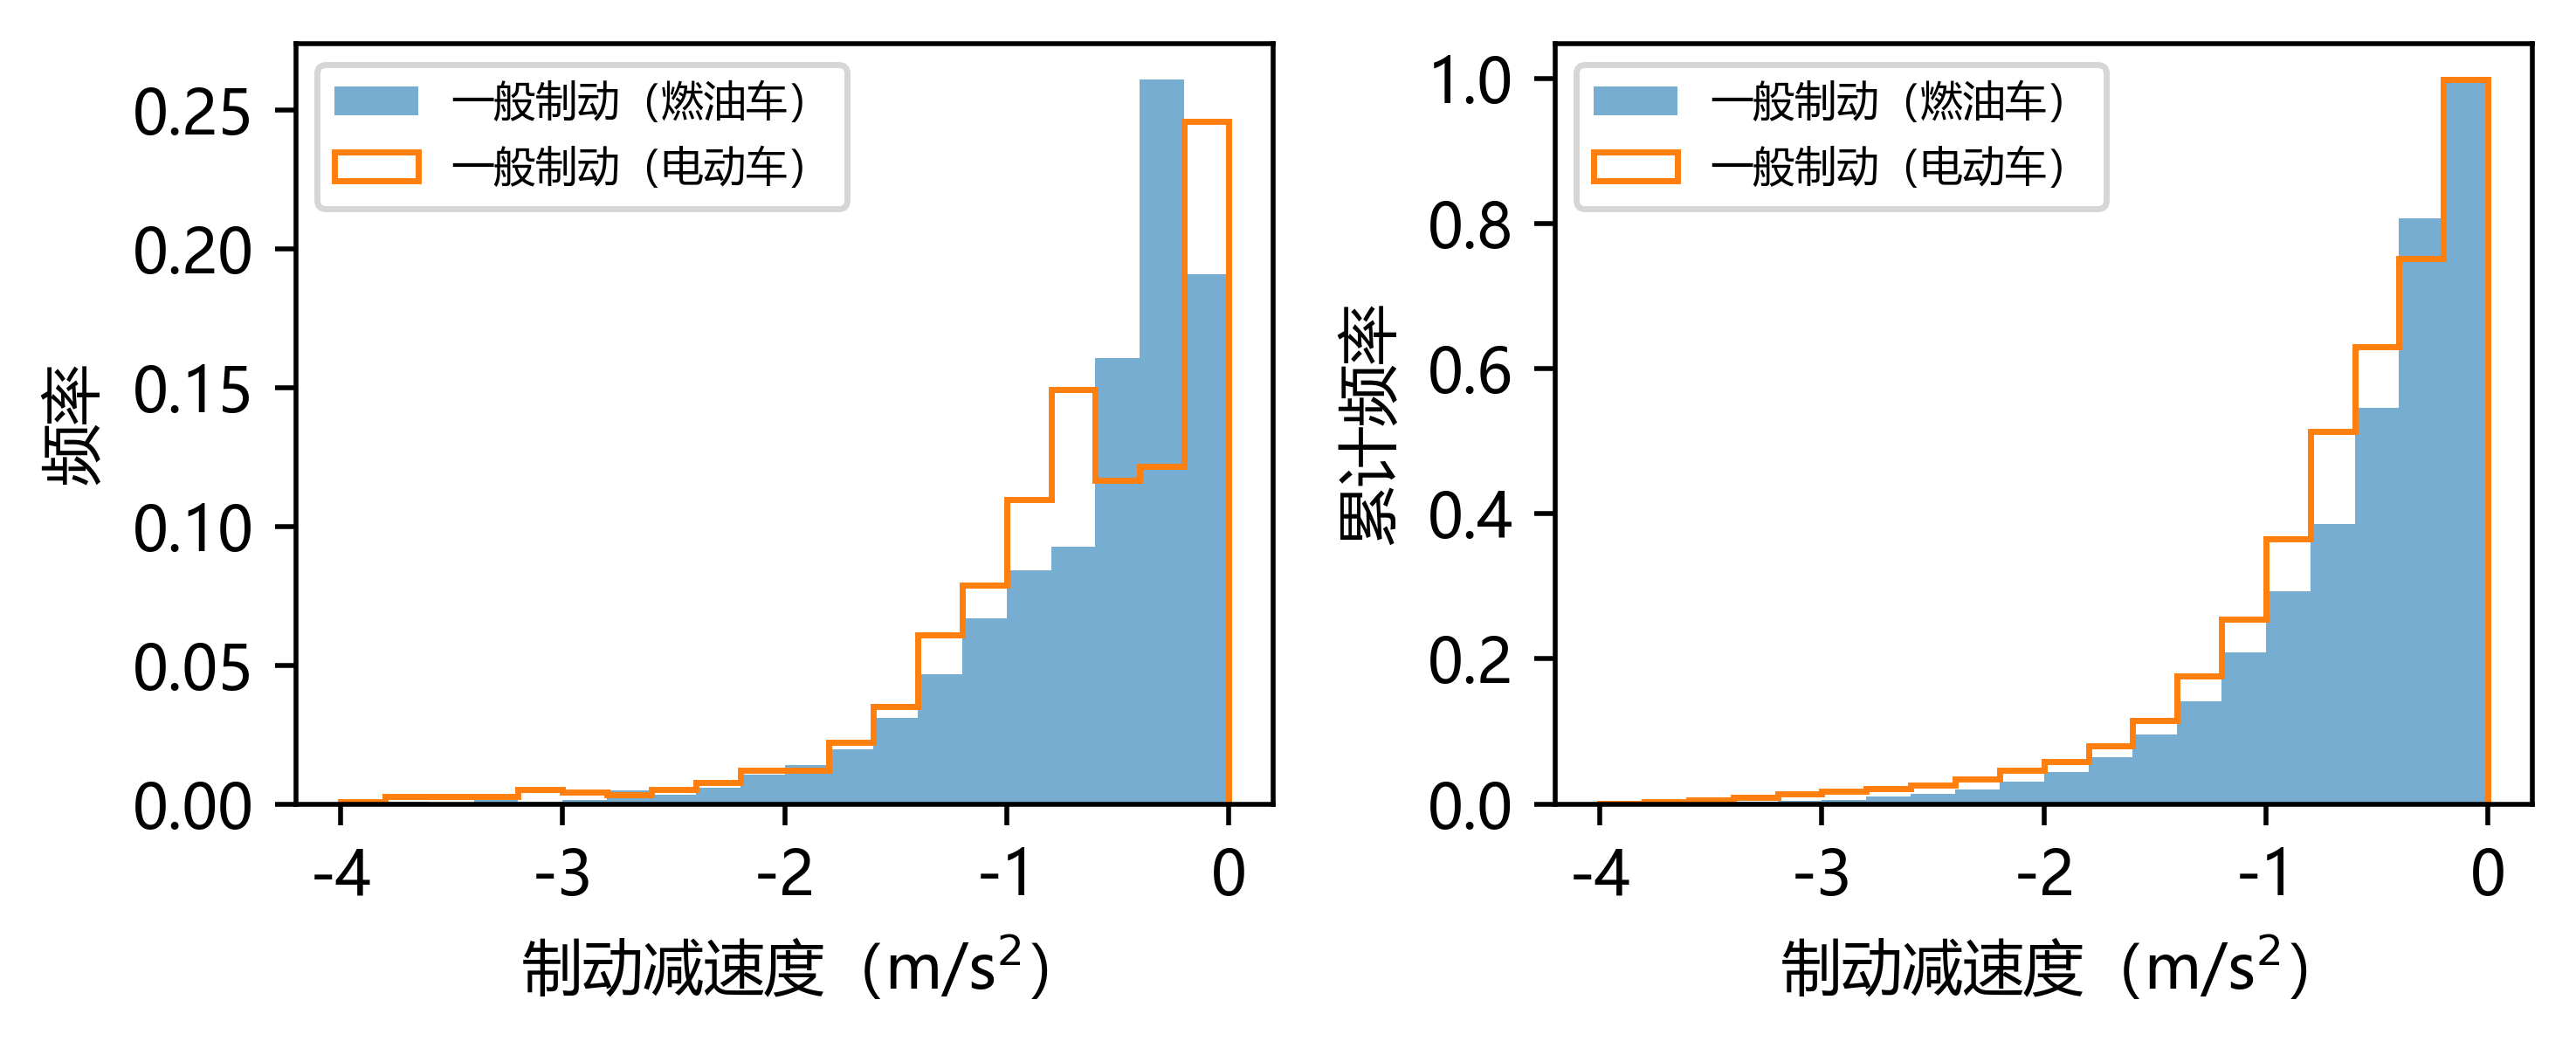

In [9]:
decel_set = pd.read_csv("data/3-braking/decel_set.csv")
braking_ev = pd.concat([braking_ei5, braking_modely])

fig, axes = plt.subplots(1,2, figsize=(6,2.5))

data1 = braking_icev['acc[m/s2]']
data2 = braking_ev['acc[m/s2]']
bins = np.arange(-4,0.1,0.2)
axes[0].hist(data1, bins=bins, weights=1/len(data1)*np.ones(len(data1)), histtype='stepfilled', alpha=0.6, label='一般制动（燃油车）')
axes[0].hist(data2, bins=bins, weights=1/len(data2)*np.ones(len(data2)), histtype='step', alpha=1, label='一般制动（电动车）')
# axes[0].set_xlim(-2,0)
axes[0].set_xlabel('制动减速度（m/s$^2$）')
axes[0].set_ylabel('频率')
axes[0].legend(fontsize='x-small')

axes[1].hist(data1, bins=bins, weights=1/len(data1)*np.ones(len(data1)), cumulative=True, histtype='stepfilled', alpha=0.6, label='一般制动（燃油车）')
axes[1].hist(data2, bins=bins, weights=1/len(data2)*np.ones(len(data2)), cumulative=True, histtype='step', alpha=1, label='一般制动（电动车）')
# axes[1].set_xlim(-2,0)
axes[1].set_xlabel('制动减速度（m/s$^2$）')
axes[1].set_ylabel('累计频率')
axes[1].legend(fontsize='x-small')

plt.tight_layout()
plt.show()

### Coastdown curve

In [2]:
# Coast down curve params for LDV from MOVES3.0
# y = -0.0001454 * x2 + 0.0000622 * x - O.1758­ (mph)
A = -0.0001454 / (1.609344 ** 2) / 3.6 * 1.609344
B = 0.0000622 / 1.609344 / 3.6 * 1.609344
C = -0.1758 / 3.6 * 1.609344

def coastDownDec(v):
    """
    Coasting deceleration value calculation according to the coast-down curve of 1497kg vehicles.
    v: speed, km/h
    return: dec, m/s^2
    """
    dec = A * v**2 + B * v + C
    return np.float32(dec)

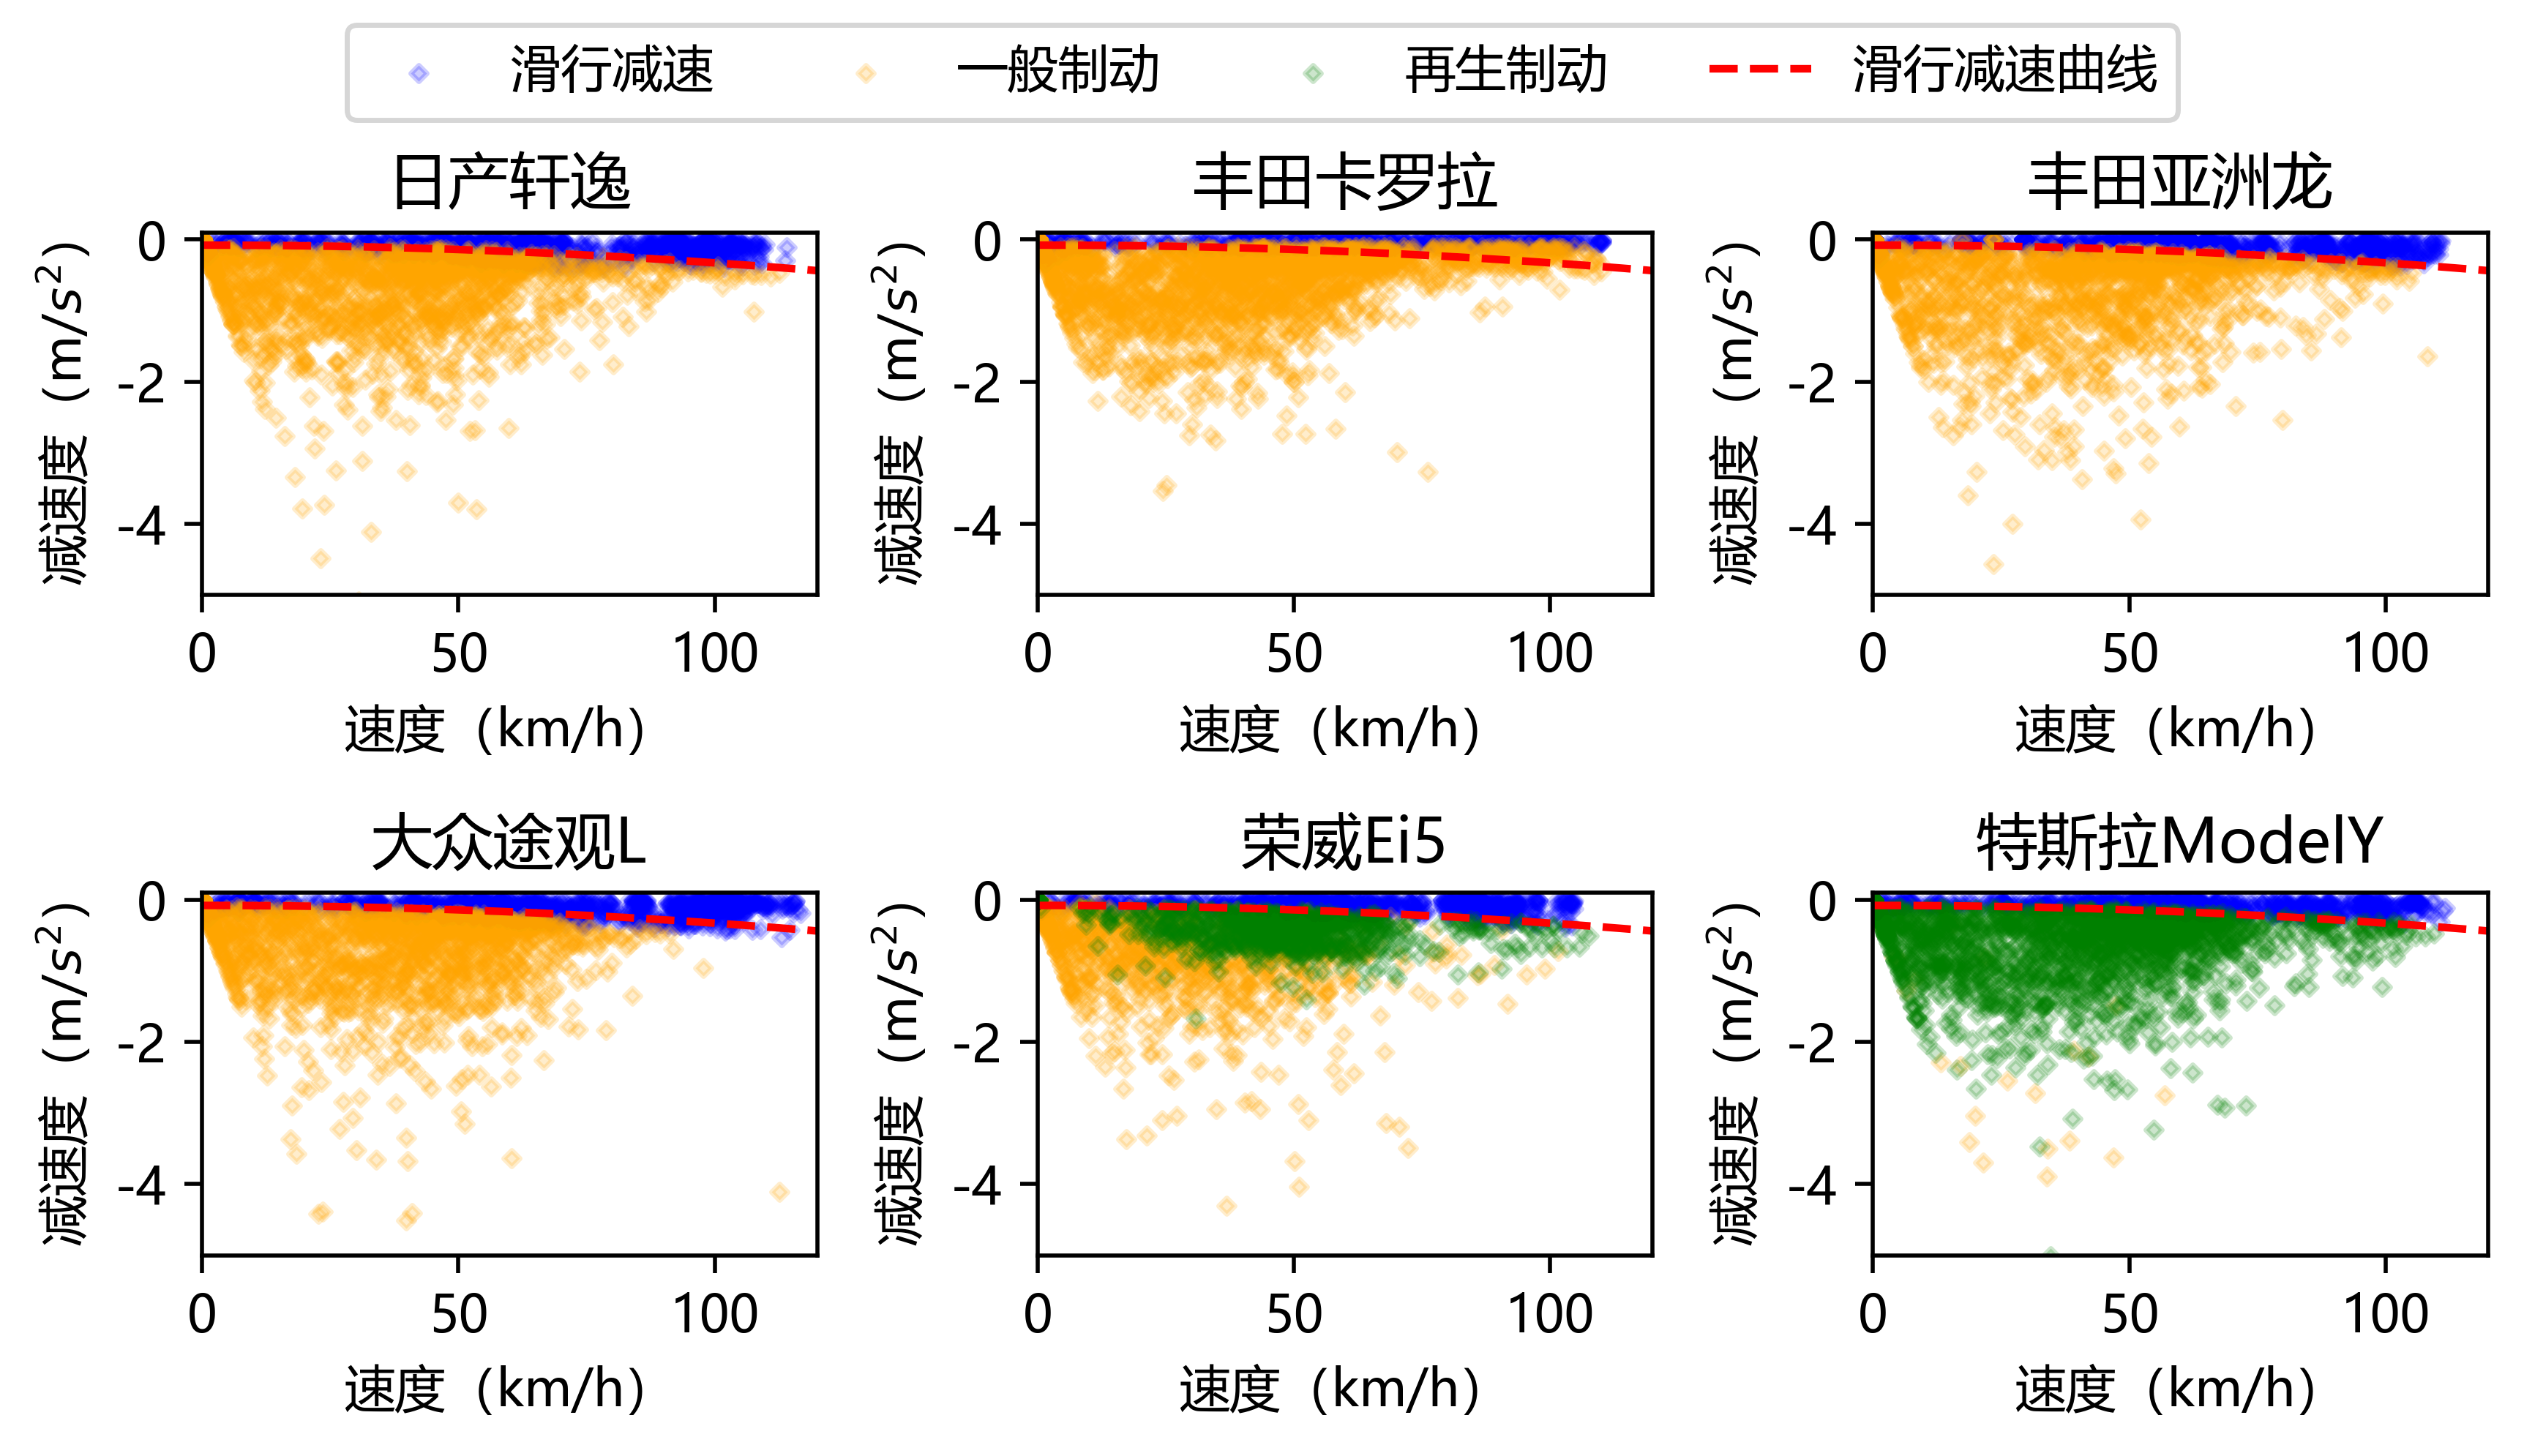

In [5]:
decel_set = pd.read_csv("data/3-braking/decel_set.csv")

fig, axes = plt.subplots(2, 3, figsize=(7,4))
axes = axes.flatten()

models = ['Sylphy', 'Corolla', 'Avalon', 'TiguanL', 'Ei5', 'ModelY']
models_CN = ['日产轩逸', '丰田卡罗拉', '丰田亚洲龙', '大众途观L', '荣威Ei5', '特斯拉ModelY']

for i, model in enumerate(models):
    model_data = decel_set[decel_set['model'] == model]
    deceleration_data = model_data[(model_data['braking'] == 0)]
    braking_data = model_data[(model_data['braking'] == 1) & (model_data['reg'] == 0)]
    reg_data = model_data[(model_data['braking'] == 1) & (model_data['reg'] == 1)]

    # points
    decel_scatter = axes[i].scatter(deceleration_data['speed[km/h]'], deceleration_data['acc[m/s2]'],
                                marker='D', alpha=0.2, c='blue', label='滑行减速', s=5)    
    brake_scatter = axes[i].scatter(braking_data['speed[km/h]'], braking_data['acc[m/s2]'],
                                    marker='D', alpha=0.2, c='orange', label='一般制动', s=5)
    reg_scatter = axes[i].scatter(reg_data['speed[km/h]'], reg_data['acc[m/s2]'],
                                  marker='D', alpha=0.2, c='green', label='再生制动', s=5)
    # coastdown curve
    speeds = np.linspace(0, 120, 100)
    decelerations = coastDownDec(speeds)
    axes[i].plot(speeds, decelerations, 'r--', label='滑行减速曲线')

    axes[i].set_title(f'{models_CN[i]}')
    axes[i].set_xlabel('速度（km/h）')
    axes[i].set_ylabel('减速度（m/$s^2$）')
    axes[i].set_xlim(0,120)
    axes[i].set_ylim(-5,0.1)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

### Precision and recall

In [31]:
import pandas as pd
score = pd.read_csv("data/3-braking/detection/score.csv")

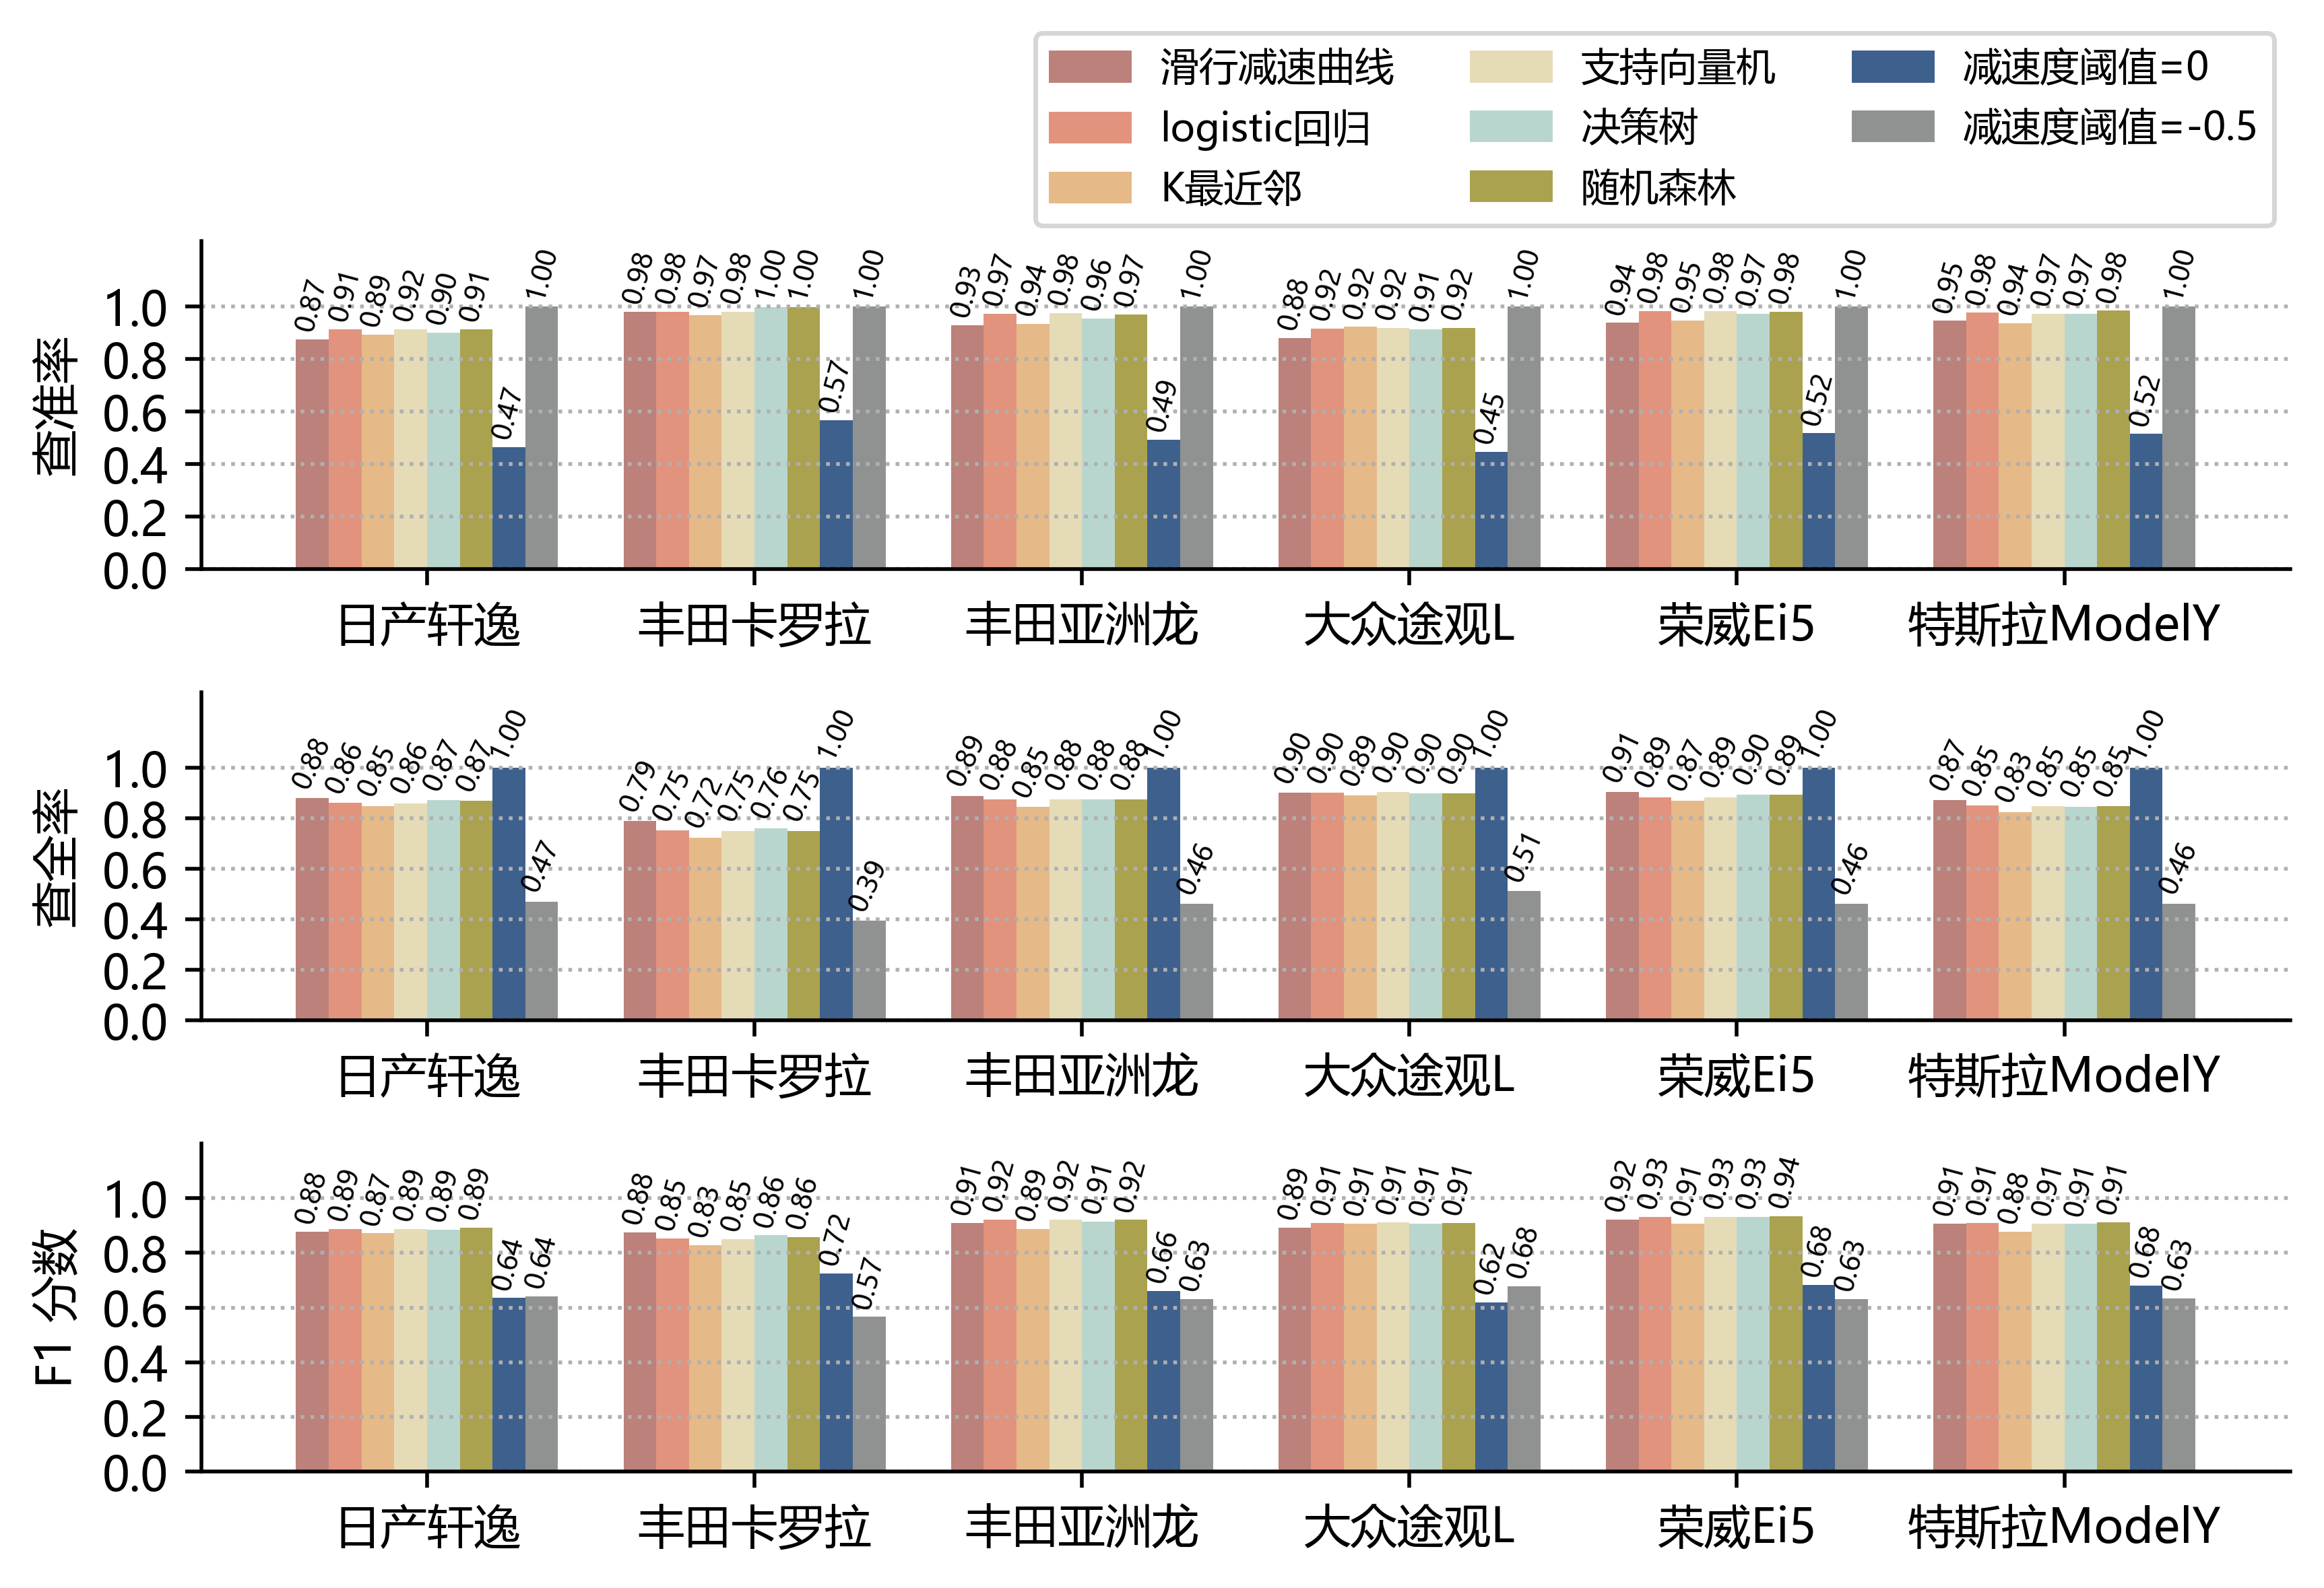

In [43]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

models = ['Sylphy', 'Corolla', 'Avalon', 'TiguanL', 'Ei5', 'ModelY']
models_CN = ['日产轩逸', '丰田卡罗拉', '丰田亚洲龙', '大众途观L', '荣威Ei5', '特斯拉ModelY']
colNames = ['coastdown curve', 'logistic regression', 'KNN', 'SVM', 'decision tree', 'random forest', 'threshold=0', 'threshold=-0.5']
colNames_CN = ['滑行减速曲线', 'logistic回归', 'K最近邻', '支持向量机', '决策树', '随机森林', '减速度阈值=0', '减速度阈值=-0.5']
colors = ['#BB817A', '#E1937D', '#E6B988', '#E5DBB6', '#B9D6CE', '#AAA24F', '#3E608D', '#909291']

fig, axes = plt.subplots(3, 1, figsize=(7,4.5))

width = 0.1
x = np.arange(len(models))

# precision
for i, colName in enumerate(colNames):
    precision = score[score['prediction_method'] == colName]['precision']
    bars = axes[0].bar(x + i * width, precision, width, label=colName, color=colors[i])
    axes[0].bar_label(bars, padding=1, fmt='%.2f', rotation=75, fontsize='xx-small')
axes[0].set_ylabel('查准率')
axes[0].set_ylim(0,1.25)
axes[0].set_xticks(x + width * (len(colNames) - 1) / 2)
axes[0].set_yticks(np.arange(0, 1.1, 0.2))
axes[0].set_xticklabels(models_CN)
axes[0].grid(axis='y', linestyle=":")
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# recall
for i, colName in enumerate(colNames):
    recall = score[score['prediction_method'] == colName]['recall']
    bars = axes[1].bar(x + i * width, recall, width, label=colName, color=colors[i])
    axes[1].bar_label(bars, padding=1, fmt='%.2f', rotation=65, fontsize='xx-small')
axes[1].set_ylabel('查全率')
axes[1].set_ylim(0,1.3)
axes[1].set_xticks(x + width * (len(colNames) - 1) / 2)
axes[1].set_yticks(np.arange(0, 1.1, 0.2))
axes[1].set_xticklabels(models_CN)
axes[1].grid(axis='y', linestyle=":")
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# f1 score
for i, colName in enumerate(colNames):
    f1_score = score[score['prediction_method'] == colName]['f1_score']
    bars = axes[2].bar(x + i * width, f1_score, width, label=colName, color=colors[i])
    axes[2].bar_label(bars, padding=1, fmt='%.2f', rotation=75, fontsize='xx-small')
axes[2].set_ylabel('F1 分数')
axes[2].set_ylim(0,1.2)
axes[2].set_xticks(x + width * (len(colNames) - 1) / 2)
axes[2].set_yticks(np.arange(0, 1.1, 0.2))
axes[2].set_xticklabels(models_CN)
axes[2].grid(axis='y', linestyle=":")
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)

# legend
legend_elements = [Patch(facecolor=color, edgecolor=color, label=colName) for color, colName in zip(colors, colNames_CN)]
fig.legend(handles=legend_elements, fontsize='small', ncols=3, bbox_to_anchor=(0.98, 1.05), bbox_transform=fig.transFigure)

# layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

### Cross entropy

In [41]:
entropy_df = pd.read_csv("data/3-braking/detection/entropy.csv")

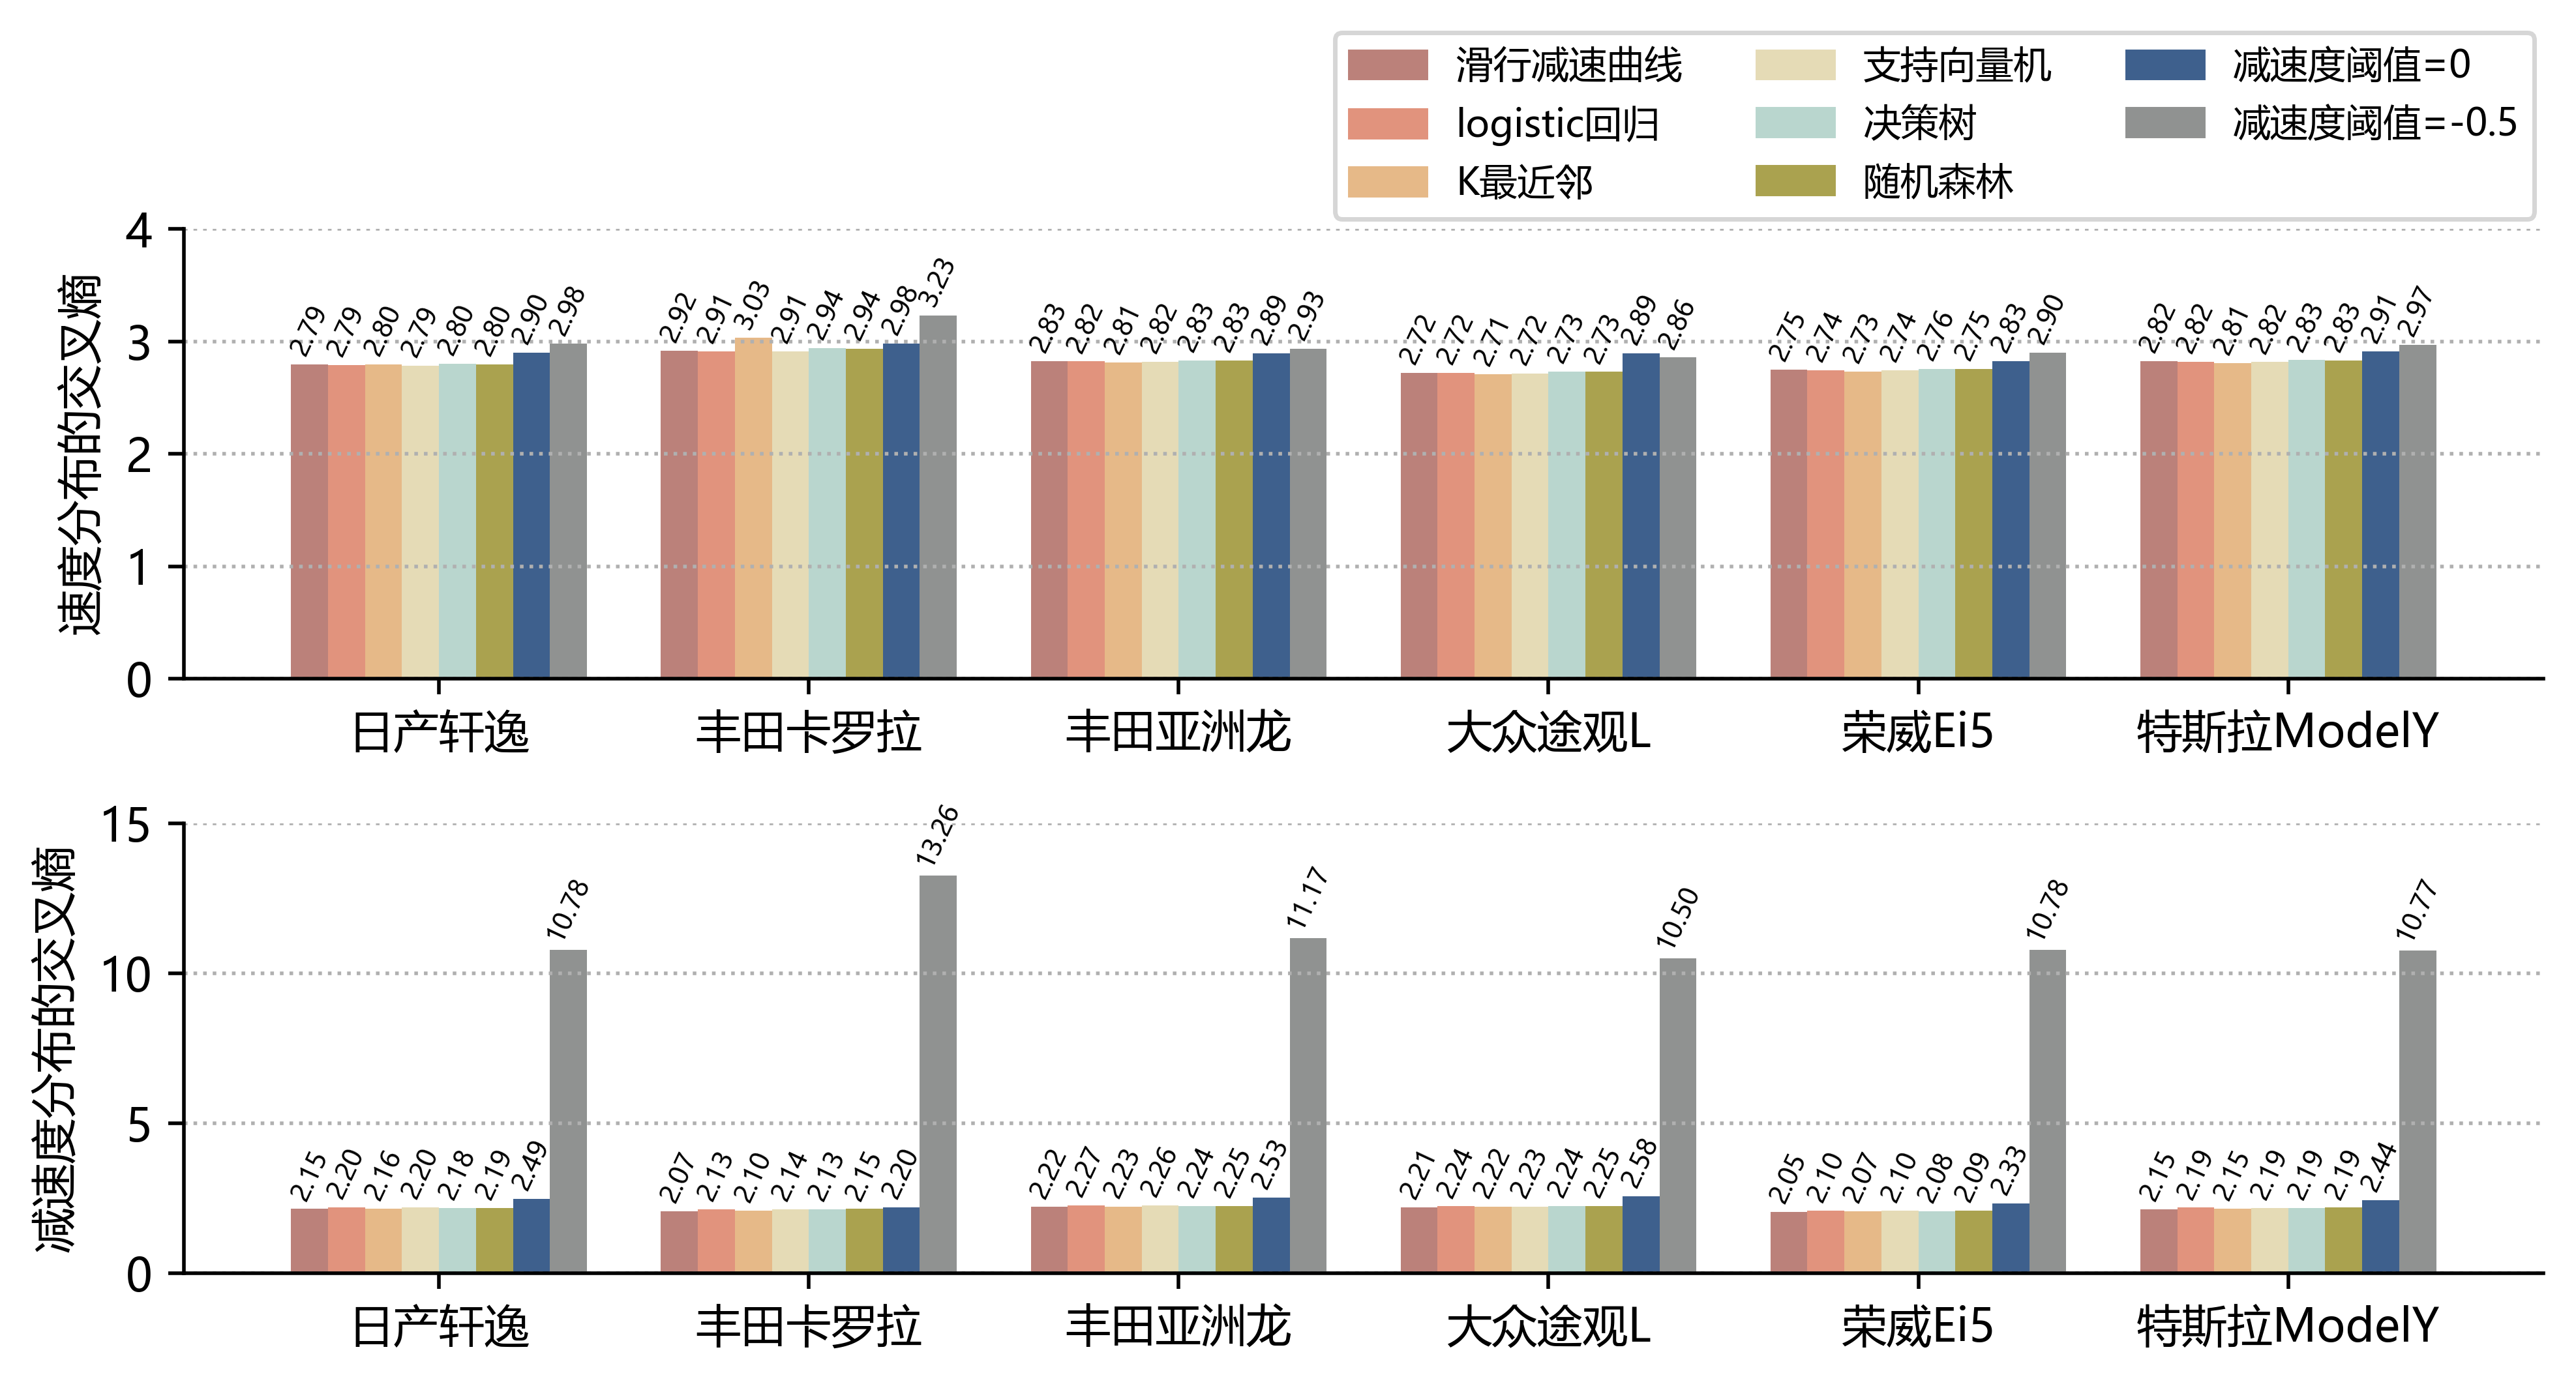

In [42]:
from matplotlib.patches import Patch

models = ['Sylphy', 'Corolla', 'Avalon', 'TiguanL', 'Ei5', 'ModelY']
models_CN = ['日产轩逸', '丰田卡罗拉', '丰田亚洲龙', '大众途观L', '荣威Ei5', '特斯拉ModelY']
colNames = ['coastdown curve', 'logistic regression', 'KNN', 'SVM', 'decision tree', 'random forest', 'threshold=0', 'threshold=-0.5']
colNames_CN = ['滑行减速曲线', 'logistic回归', 'K最近邻', '支持向量机', '决策树', '随机森林', '减速度阈值=0', '减速度阈值=-0.5']
colors = ['#BB817A', '#E1937D', '#E6B988', '#E5DBB6', '#B9D6CE', '#AAA24F', '#3E608D', '#909291']

fig, axes = plt.subplots(2, 1, figsize=(8, 4))

width = 0.1
x = np.arange(len(models))

# speed entropy
for i, colName in enumerate(colNames):
    result = entropy_df[entropy_df['prediction_method'] == colName]['cross_entropy_speed']
    bars = axes[0].bar(x + i * width, result, width, label=colNames[i], color=colors[i])
    axes[0].bar_label(bars, padding=1, fmt='%.2f', rotation=65, fontsize='xx-small')
axes[0].set_ylabel('速度分布的交叉熵')
axes[0].set_ylim(0,4)
axes[0].set_xticks(x + width * (len(colNames) - 1) / 2)
axes[0].set_xticklabels(models_CN)
axes[0].grid(axis='y', linestyle=":")
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# acc entropy
for i, colName in enumerate(colNames):
    result = entropy_df[entropy_df['prediction_method'] == colName]['cross_entropy_acc']
    bars = axes[1].bar(x + i * width, result, width, label=colNames[i], color=colors[i])
    axes[1].bar_label(bars, padding=1, fmt='%.2f', rotation=65, fontsize='xx-small')
axes[1].set_ylabel('减速度分布的交叉熵')
axes[1].set_ylim(0,15)
axes[1].set_xticks(x + width * (len(colNames) - 1) / 2)
axes[1].set_xticklabels(models_CN)
axes[1].grid(axis='y', linestyle=":")
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# legend
legend_elements = [Patch(facecolor=color, edgecolor=color, label=colName) for color, colName in zip(colors, colNames_CN)]
fig.legend(handles=legend_elements, fontsize='small', ncols=3, bbox_to_anchor=(0.985, 1.065), bbox_transform=fig.transFigure)

# layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

### Distribution of speed and acc

In [2]:
decel_set = pd.read_csv("data/3-braking/detection/decel_set_detected.csv")

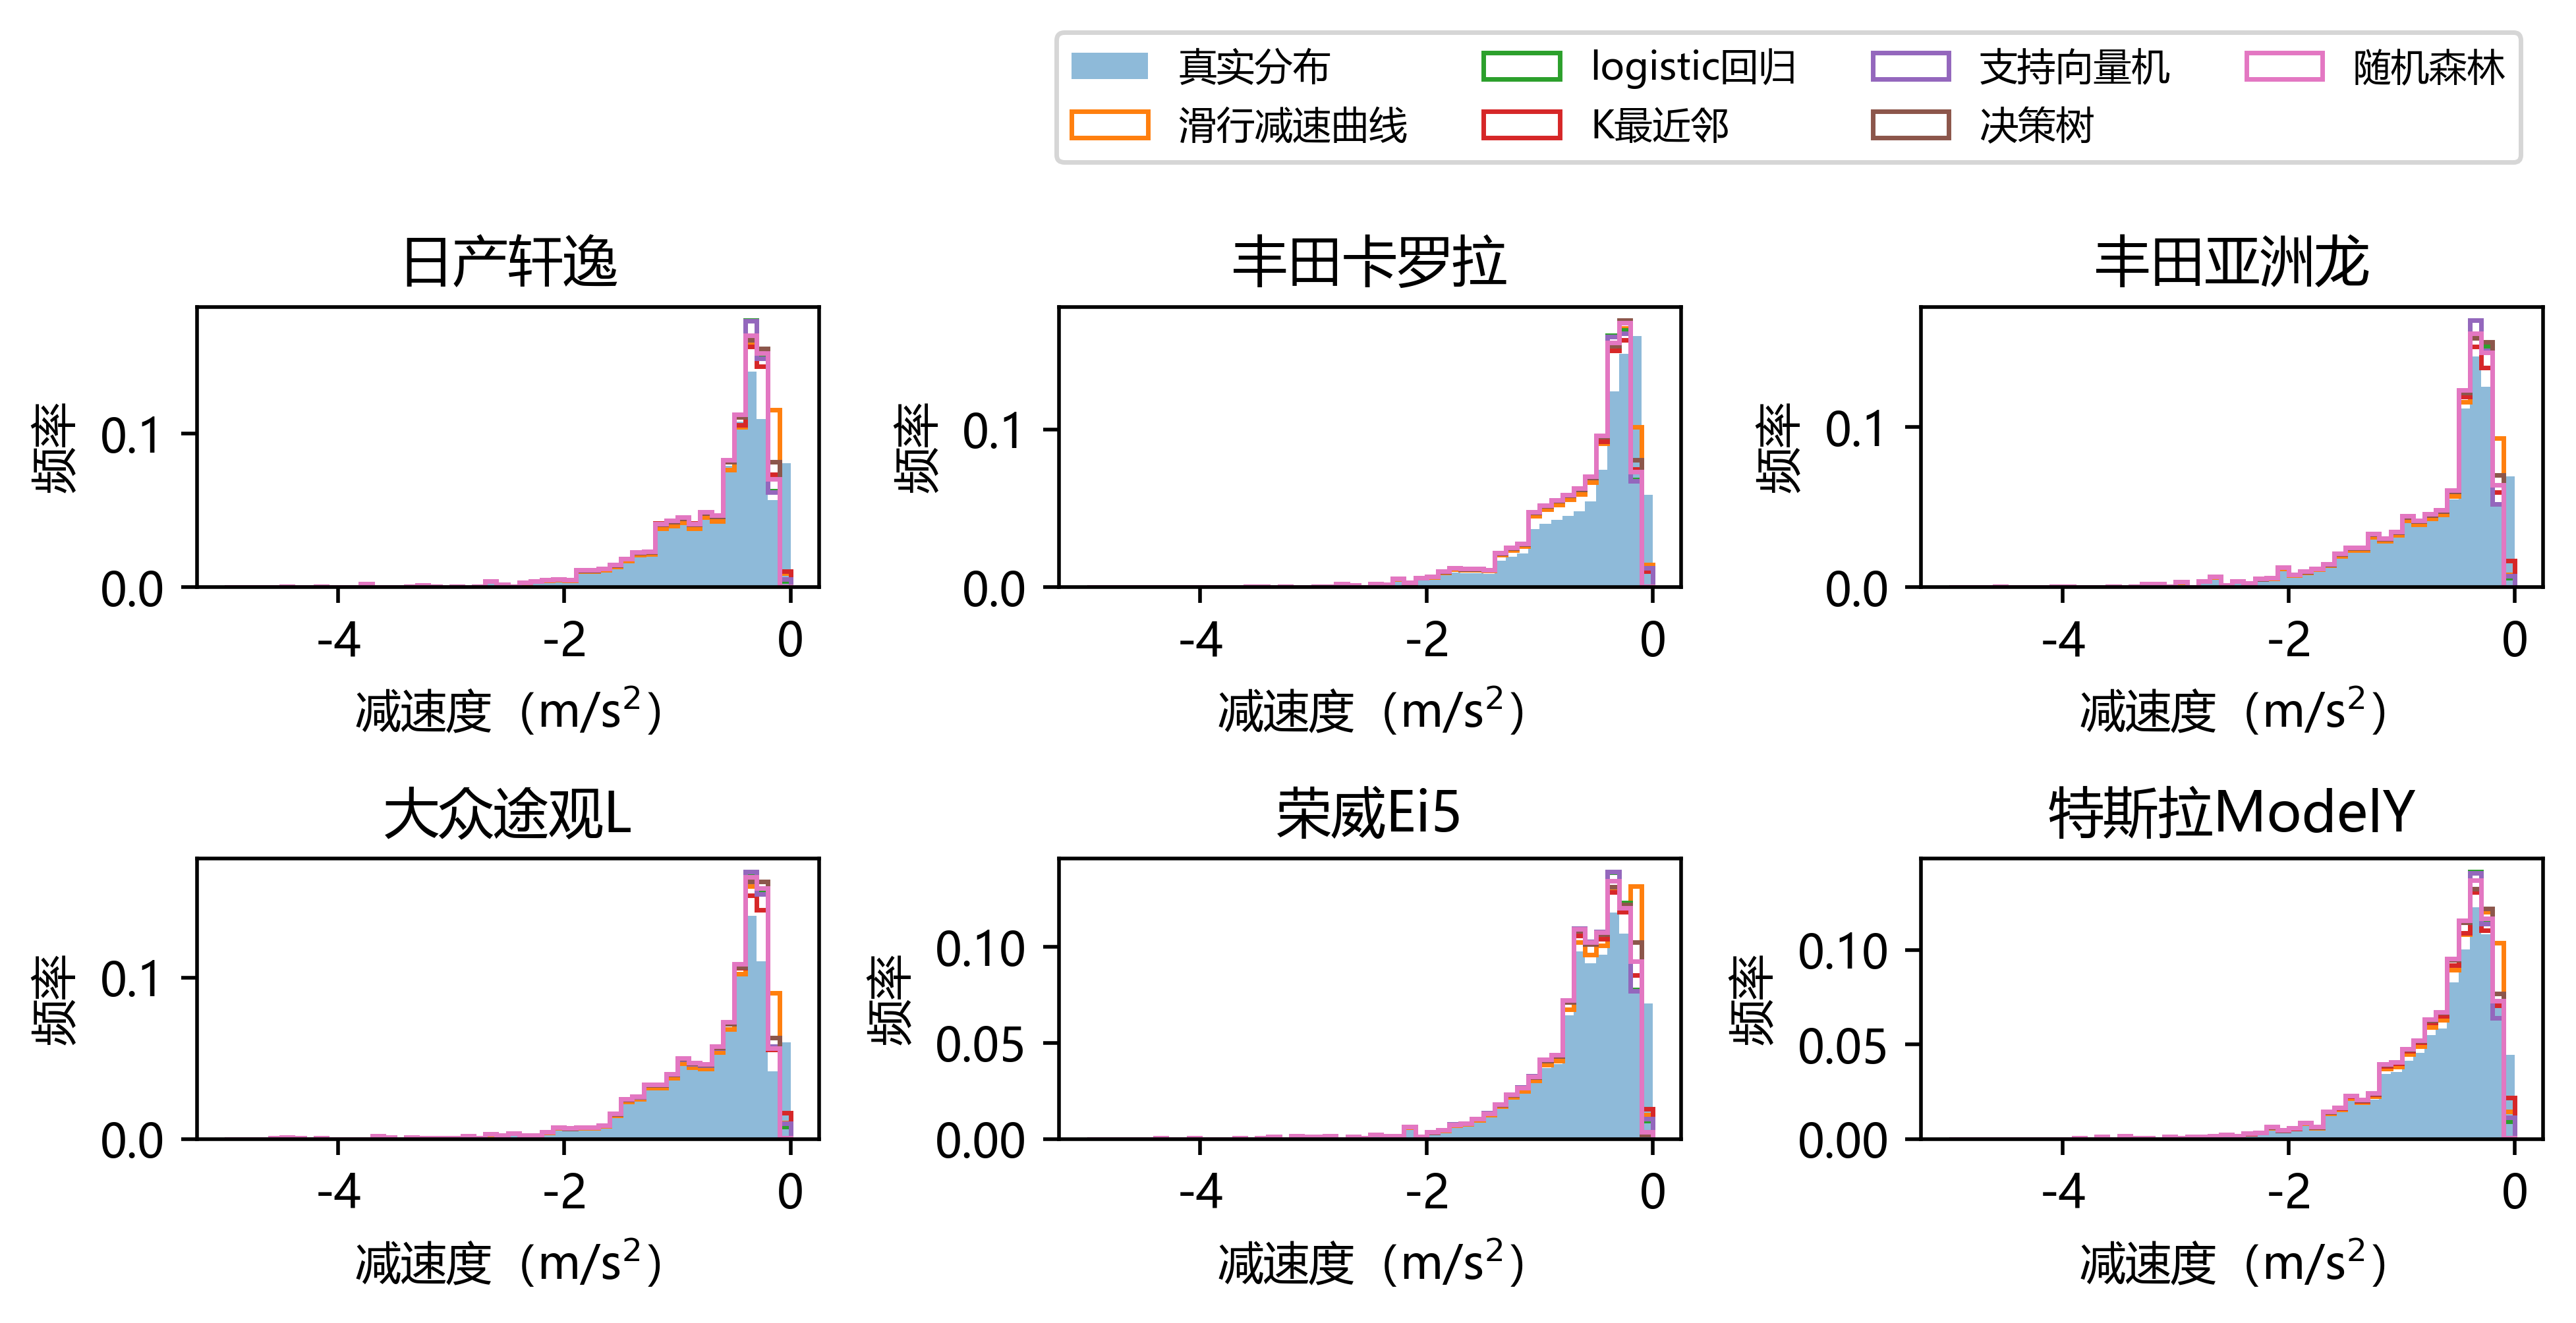

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

models = ['Sylphy', 'Corolla', 'Avalon', 'TiguanL', 'Ei5', 'ModelY']
models_CN = ['日产轩逸', '丰田卡罗拉', '丰田亚洲龙', '大众途观L', '荣威Ei5', '特斯拉ModelY']
predCols = ['braking', 'braking_CD', 'braking_LR', 'braking_KNN', 'braking_SVM', 'braking_DT', 'braking_RF']
colNames_CN = ['真实分布', '滑行减速曲线', 'logistic回归', 'K最近邻', '支持向量机', '决策树', '随机森林']

fig, axes = plt.subplots(2, 3, figsize=(8,3.5))
axes = axes.flatten()

acc_bins = list(np.arange(-5,0.1,0.1))

for i, model in enumerate(models):
    model_data = decel_set[decel_set['model'] == model]
    
    for j, col in enumerate(predCols):
        data = model_data[model_data[col] == 1]['acc[m/s2]']
        num_data_points = len(data)
        weights = [1 / num_data_points] * num_data_points
        if col == 'braking':
            axes[i].hist(data, bins=acc_bins, weights=weights, histtype='stepfilled', alpha=0.5, label=colNames_CN[j])
        else:
            axes[i].hist(data, bins=acc_bins, weights=weights, histtype='step', label=colNames_CN[j])
    
    axes[i].set_title(f'{models_CN[i]}')
    axes[i].set_xlabel('减速度（m/s$^2$）')
    axes[i].set_ylabel('频率')

# legend
handles = []
labels = []
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, fontsize='small', ncols=4, bbox_to_anchor=(0.98, 1.15), bbox_transform=fig.transFigure)

plt.tight_layout()
plt.show()

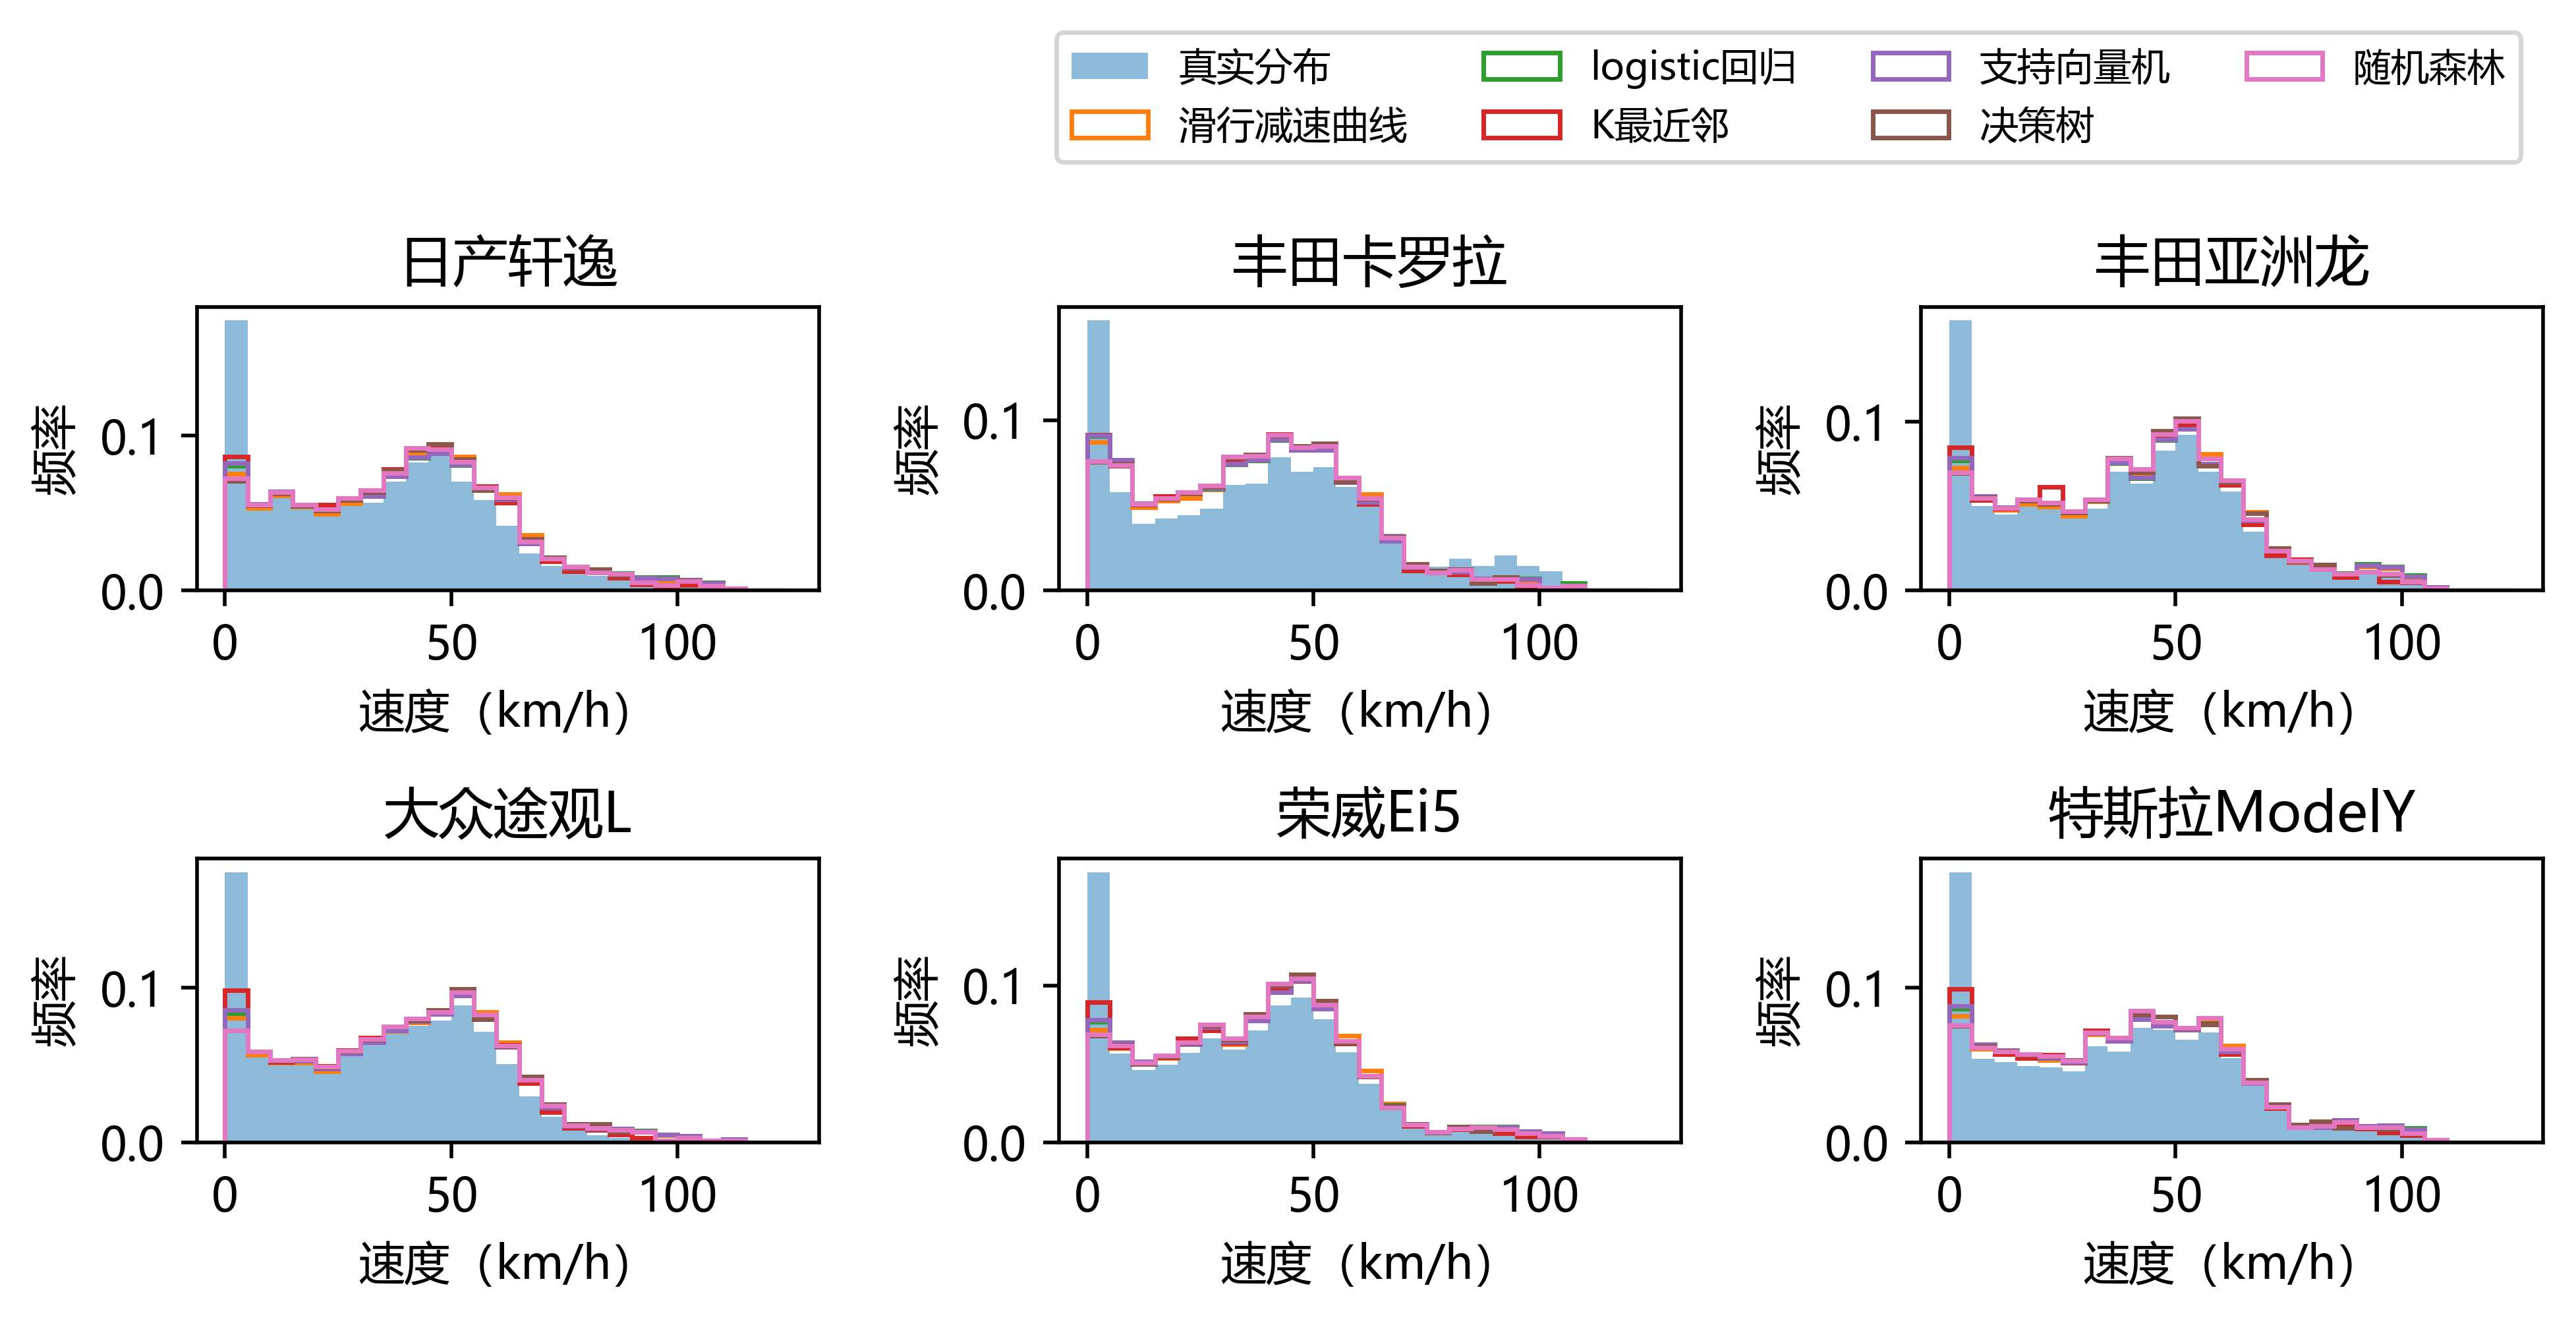

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

models = ['Sylphy', 'Corolla', 'Avalon', 'TiguanL', 'Ei5', 'ModelY']
models_CN = ['日产轩逸', '丰田卡罗拉', '丰田亚洲龙', '大众途观L', '荣威Ei5', '特斯拉ModelY']
predCols = ['braking', 'braking_CD', 'braking_LR', 'braking_KNN', 'braking_SVM', 'braking_DT', 'braking_RF']
colNames_CN = ['真实分布', '滑行减速曲线', 'logistic回归', 'K最近邻', '支持向量机', '决策树', '随机森林']

fig, axes = plt.subplots(2, 3, figsize=(8,3.5))
axes = axes.flatten()

speed_bins = list(range(0,130,5))

for i, model in enumerate(models):
    model_data = decel_set[decel_set['model'] == model]
    
    for j, col in enumerate(predCols):
        data = model_data[model_data[col] == 1]['speed[km/h]']
        num_data_points = len(data)
        weights = [1 / num_data_points] * num_data_points
        if col == 'braking':
            axes[i].hist(data, bins=speed_bins, weights=weights, histtype='stepfilled', alpha=0.5, label=colNames_CN[j])
        else:
            axes[i].hist(data, bins=speed_bins, weights=weights, histtype='step', label=colNames_CN[j])
    
    axes[i].set_title(f'{models_CN[i]}')
    axes[i].set_xlabel('速度（km/h）')
    axes[i].set_ylabel('频率')

# legend
handles = []
labels = []
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, fontsize='small', ncols=4, bbox_to_anchor=(0.98, 1.15), bbox_transform=fig.transFigure)

plt.tight_layout()
plt.show()